# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=4):
    data = StockDataProvider(ticker_name, start=start, end=end)
    optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
    print('Running genetic algorithm ...')
    hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3)
    print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
    gbm = GeometricBrownianMotion(data)
    crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
    print('Running backtesting ...')
    best_individual = crossvalidator.run(num_iterations=100, time_steps=252)
    del data
    del optimizer
    del gbm
    del crossvalidator    
    return best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, _ = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	647   	-68.2149	22.0738	-17.1252	14.0355
2  	648   	-113.777	26.7178	-8.02238	12.5078
3  	669   	-113.777	29.4437	-2.75432	11.9377
4  	659   	-113.899	37.1837	0.742014	10.6876
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]
Best average net profit: 2.544997586002385
CPU times: user 6min 25s, sys: 247 ms, total: 6min 25s
Wall time: 6min 26s


In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[21, 46, 121], [177], [23, 3]]
Net profit of strategy: 10.582000
Net profit of buy and hold: 21.888200
Percentage profit of strategy: 11.608161%
Percentage profit of buy and hold: 24.010750%
Number of buy signals: 1
Number of sell signals: 1


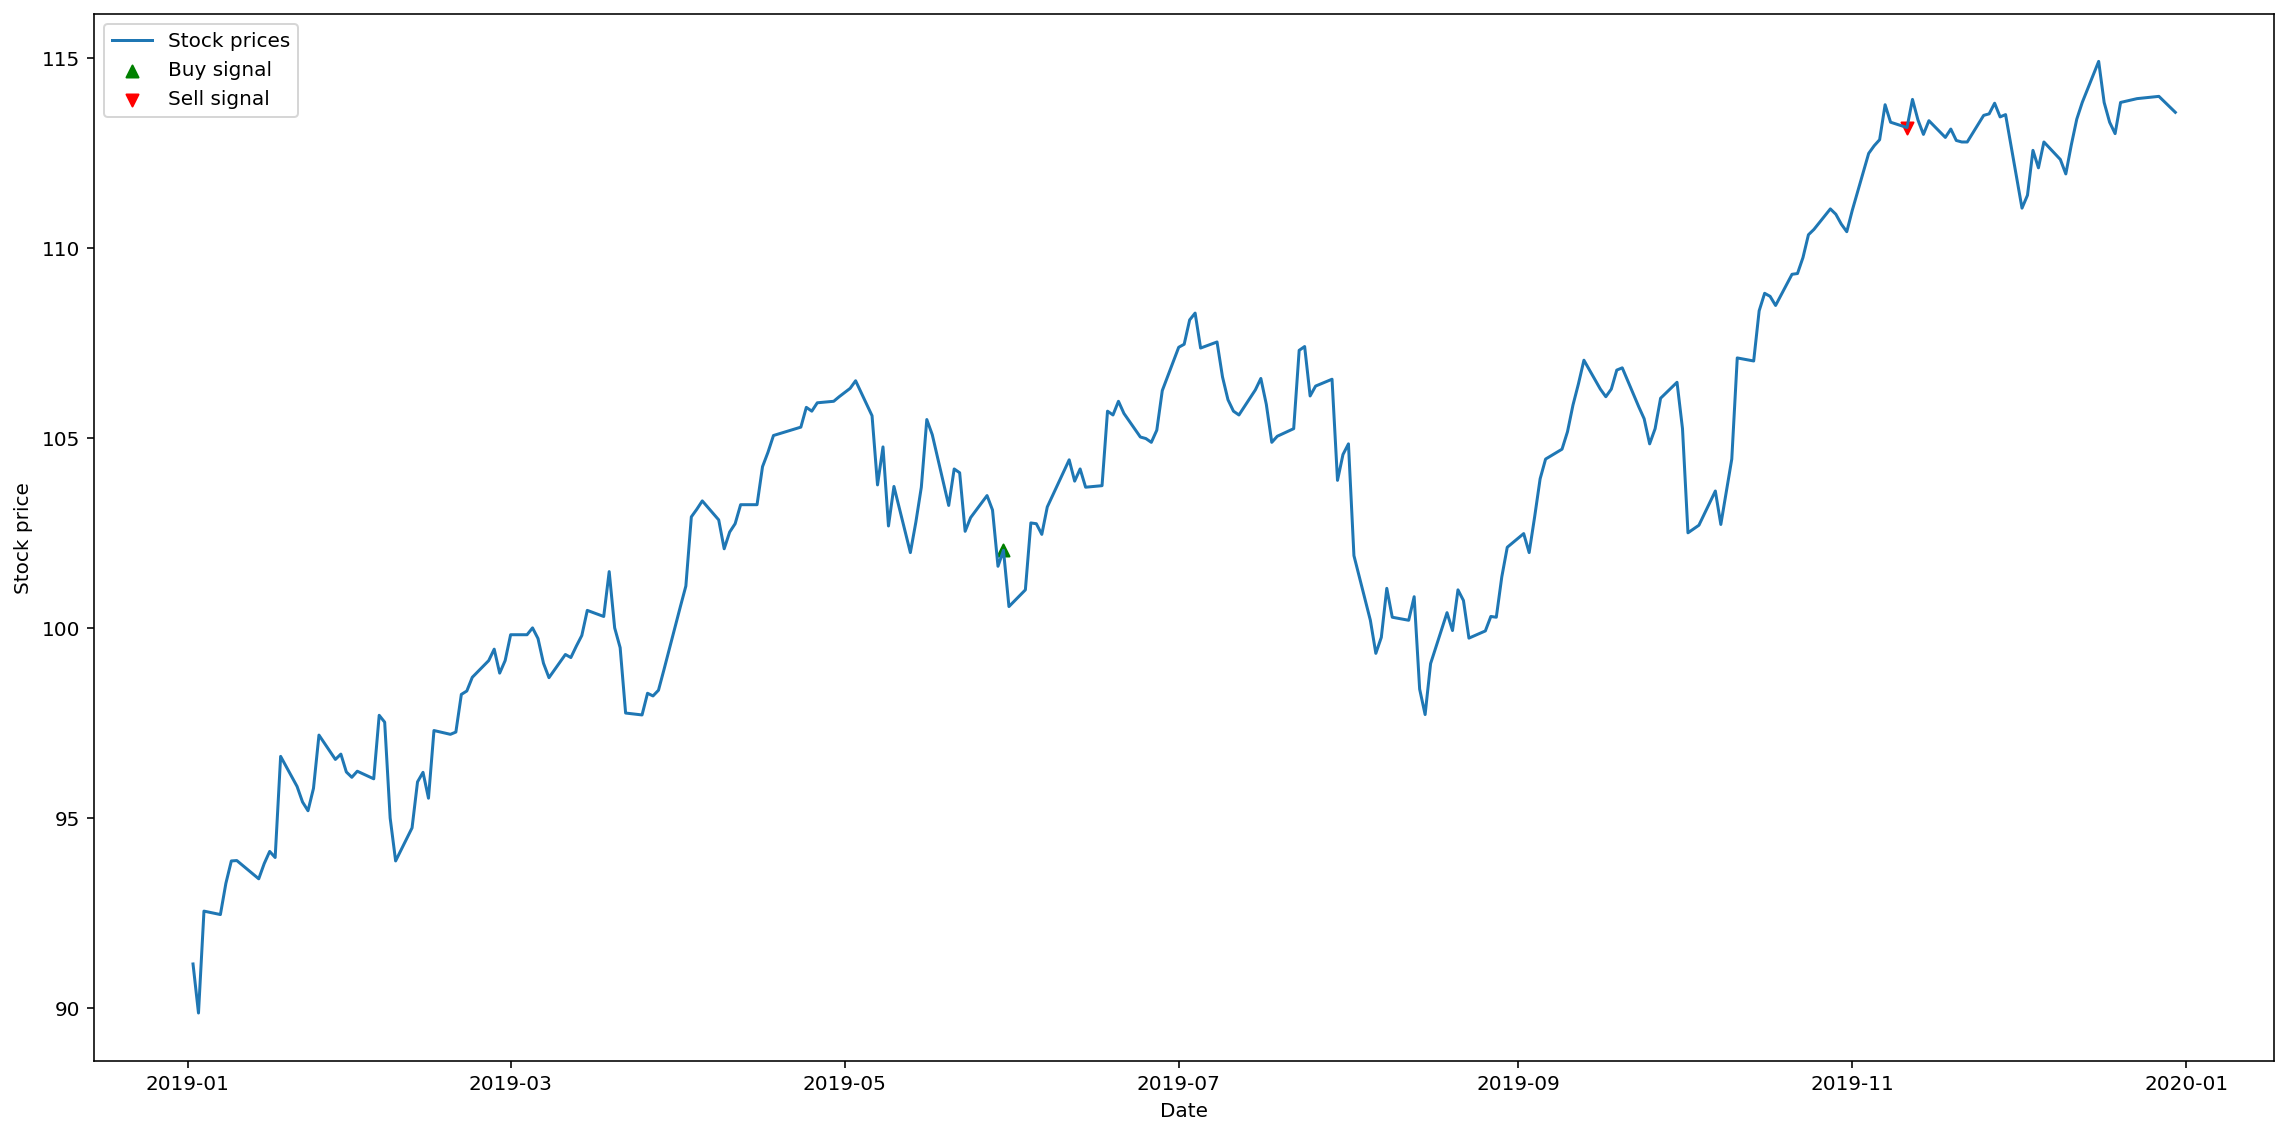

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2016-01-01', end='2018-12-31', ngen=4)

/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-154.613	94.8027	-4.46141	35.9584
1  	647   	-140.242	104.282	18.4735 	28.9277
2  	648   	-139.276	115.915	32.0859 	26.9895
3  	669   	-140.289	118.468	42.9047 	27.8845
4  	659   	-137.19 	118.468	53.5652 	28.6967
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Best average net profit: 33.56528285591131
CPU times: user 6min 28s, sys: 213 ms, total: 6min 29s
Wall time: 6min 29s


In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'BollingerBaender']
Active rules' parameters: [[111, 166], [6, 48, 9], [0, 6]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 104.593925
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 58.648607%
Number of buy signals: 0
Number of sell signals: 0


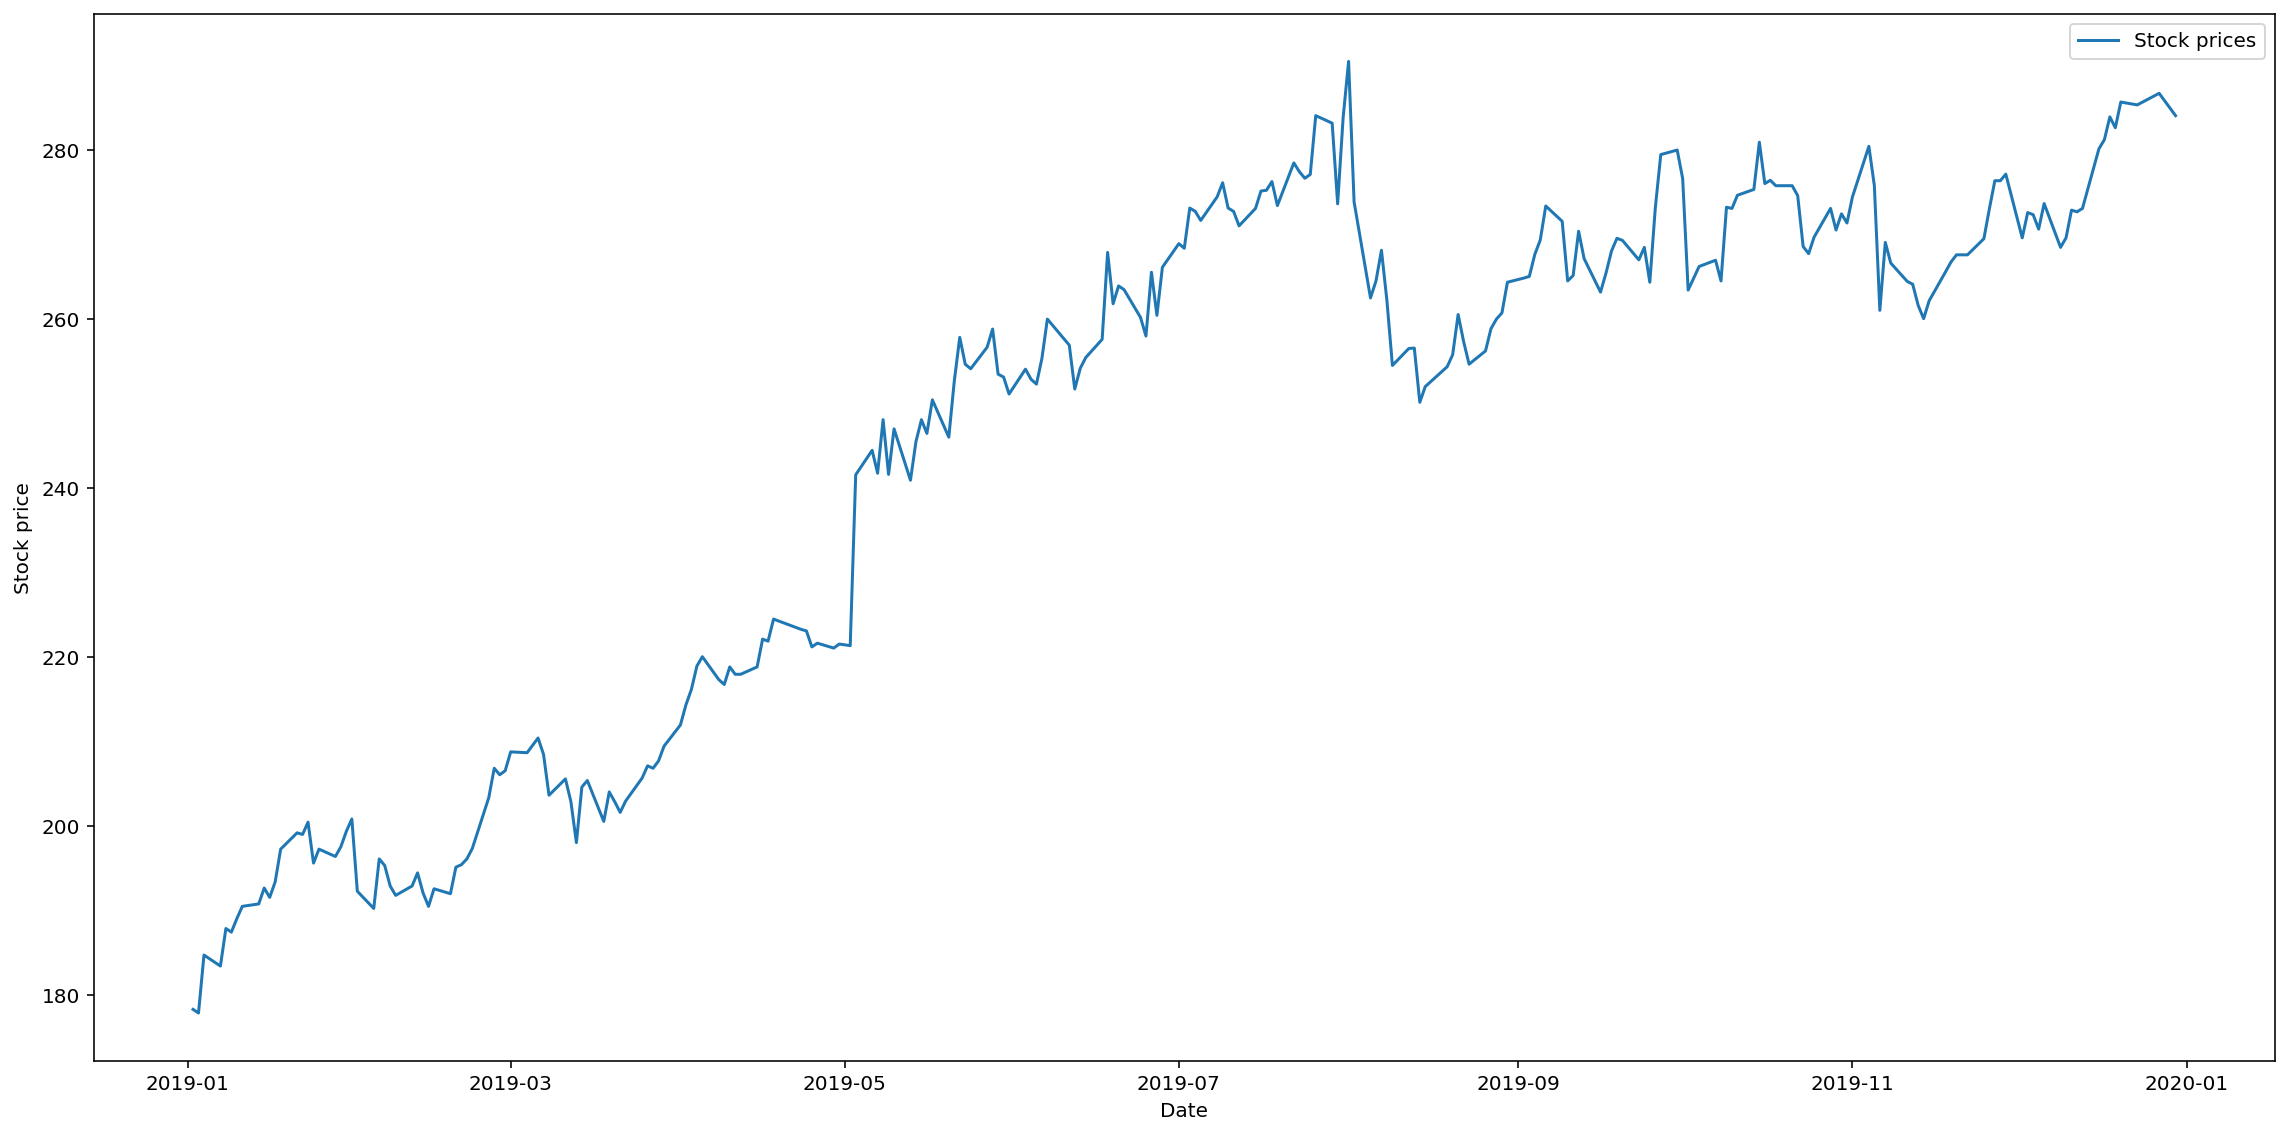

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min    	max    	mean    	std    
0  	1000  	-144.68	47.3148	-18.9056	23.3736
1  	647   	-75.6499	56.3798	-2.53113	18.1415
2  	648   	-120.137	61.6673	8.16497 	19.3467
3  	669   	-122.996	58.9658	16.5632 	19.7787
4  	659   	-119.95 	62.1555	23.7642 	18.486 
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]
Best average net profit: 14.936606759548503
CPU times: user 6min 12s, sys: 212 ms, total: 6min 12s
Wall time: 6min 12s


In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[11, 46, 121], [177], [22, 4]]
Net profit of strategy: 30.195100
Net profit of buy and hold: 47.002725
Percentage profit of strategy: 19.171492%
Percentage profit of buy and hold: 29.843000%
Number of buy signals: 3
Number of sell signals: 3


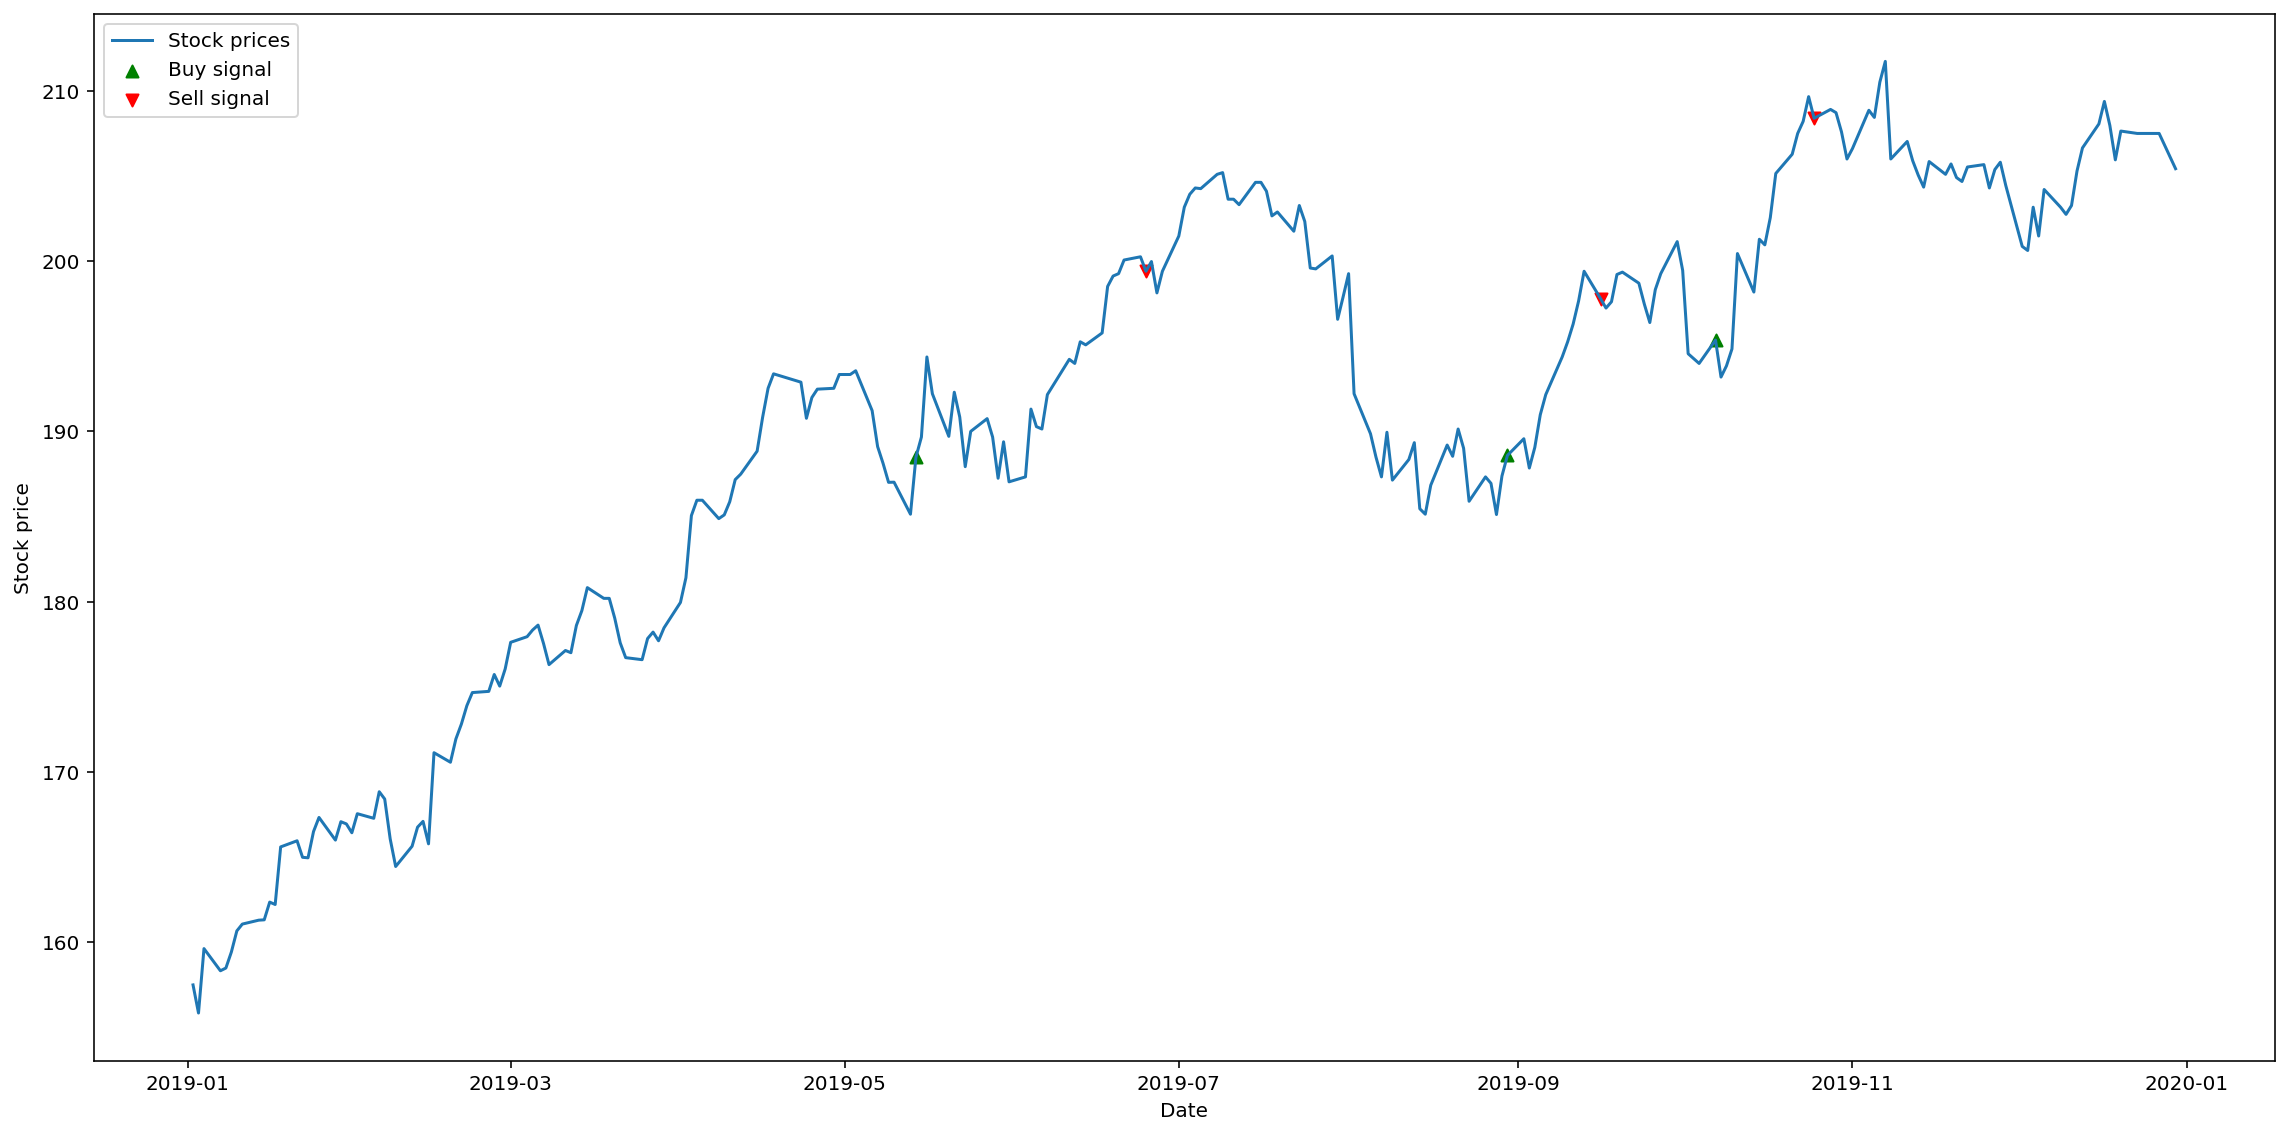

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-67.1786	17.4502	-12.4406	12.3205
1  	647   	-59.4267	19.1619	-4.31795	9.21455
2  	648   	-67.0082	19.3982	0.687236	9.10234
3  	669   	-59.0443	24.6319	4.72544 	8.42348
4  	659   	-59.4267	25.5234	7.63261 	9.11758
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Best average net profit: 0.5110587810221476
CPU times: user 6min, sys: 193 ms, total: 6min 1s
Wall time: 6min 1s


In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[7, 43, 111], [117], [1, 4]]
Net profit of strategy: 12.557100
Net profit of buy and hold: 7.846450
Percentage profit of strategy: 24.791905%
Percentage profit of buy and hold: 15.491510%
Number of buy signals: 6
Number of sell signals: 6


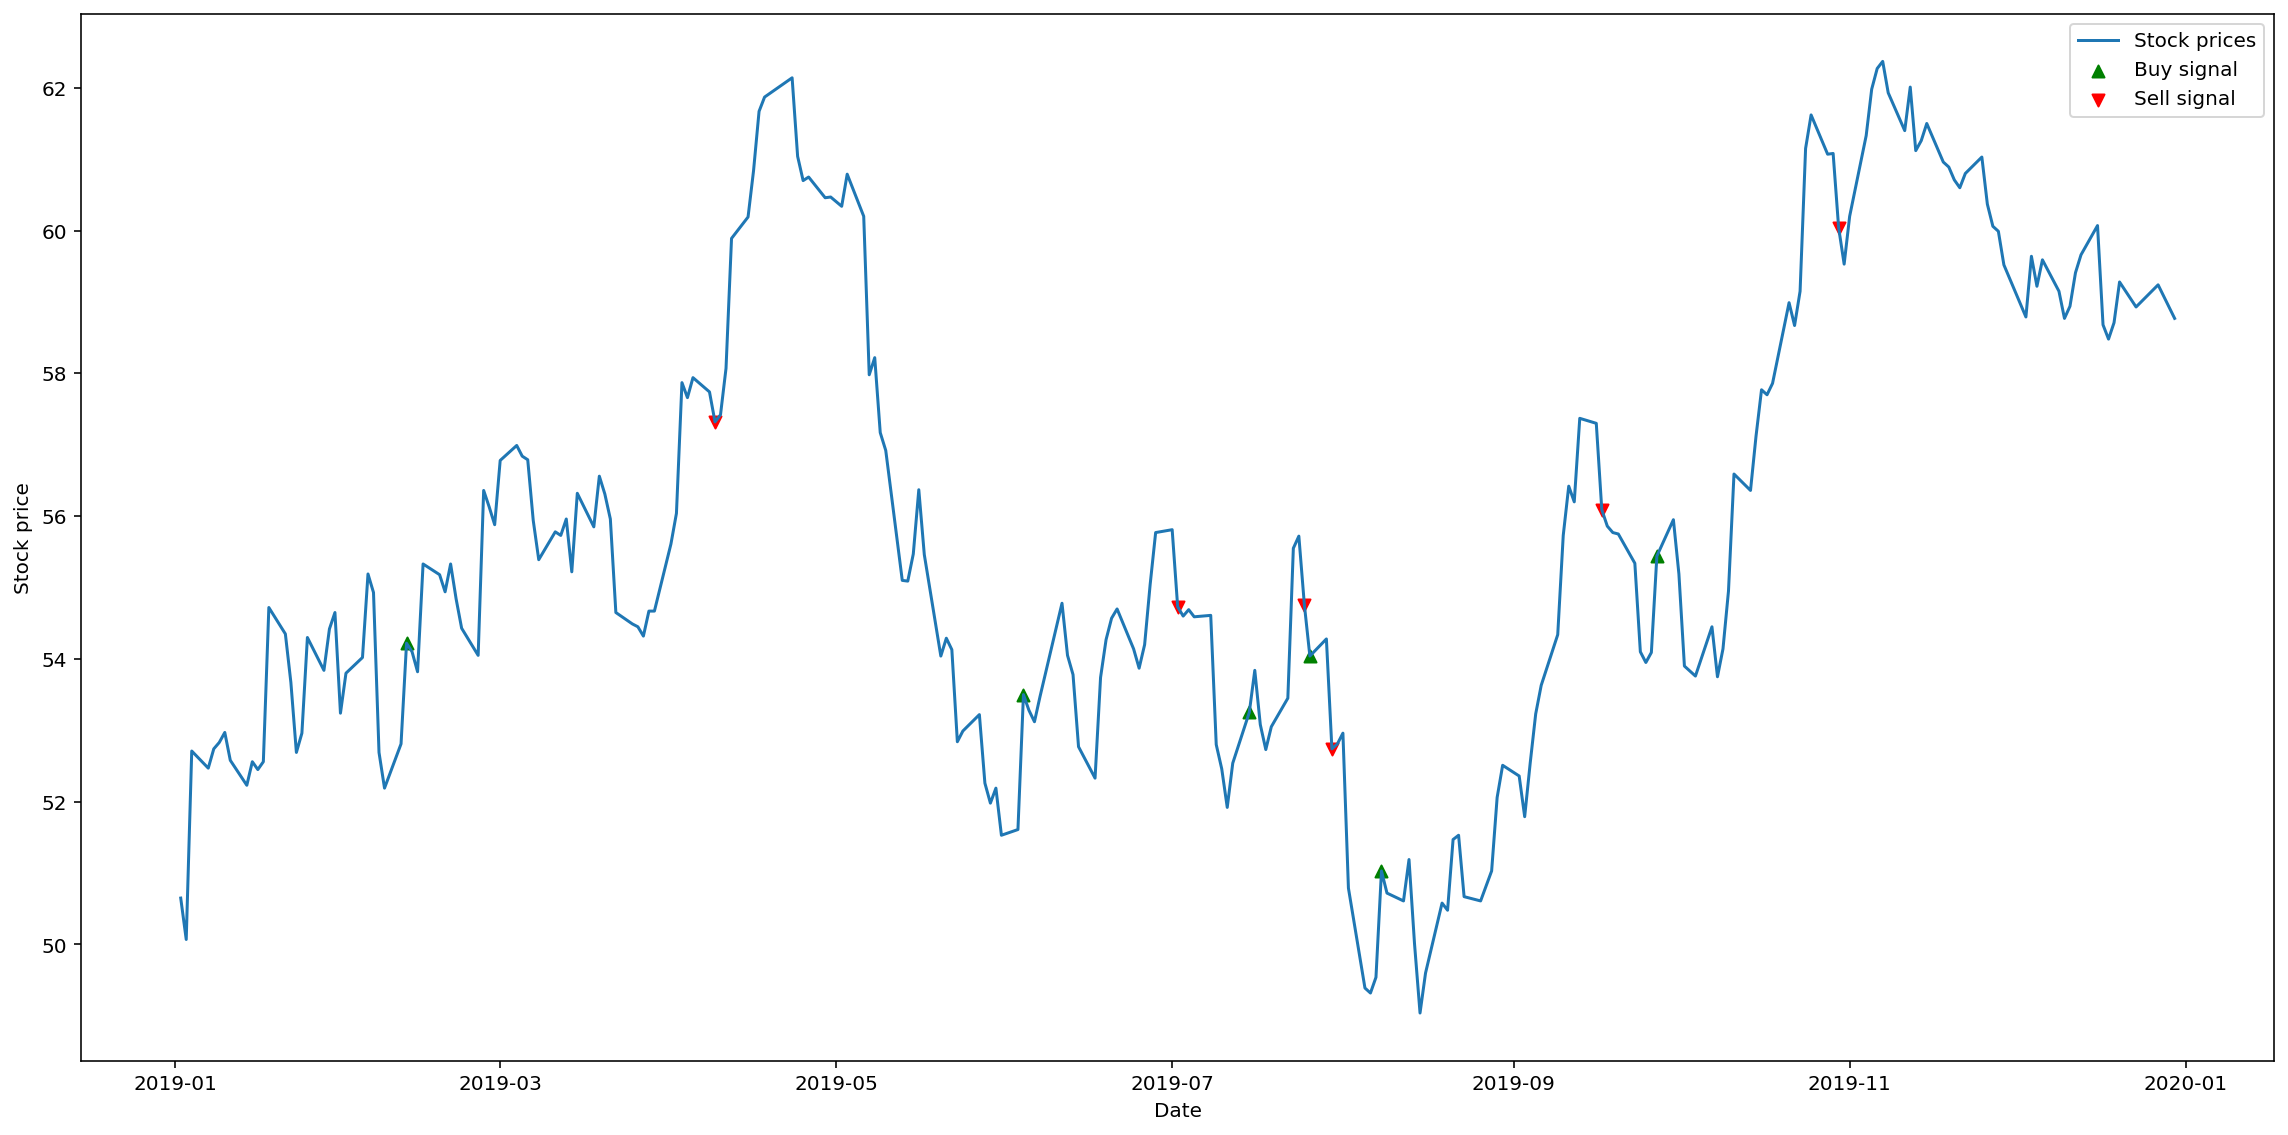

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-15.7653	2.97725	-4.7023	3.2932
1  	647   	-14.4912	3.52672	-2.59794	2.74614
2  	648   	-13.1124	4.22185	-1.20638	2.47349
3  	669   	-13.2709	5.19232	-0.297019	2.22954
4  	659   	-10.9019	6.61455	0.209062 	2.31825
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
Best average net profit: -0.024727125776764027
CPU times: user 6min 22s, sys: 280 ms, total: 6min 23s
Wall time: 6min 23s


In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[187], [118, 66, 104], [7, 0]]
Net profit of strategy: -0.648875
Net profit of buy and hold: -0.144875
Percentage profit of strategy: -9.230085%
Percentage profit of buy and hold: -2.060811%
Number of buy signals: 4
Number of sell signals: 4


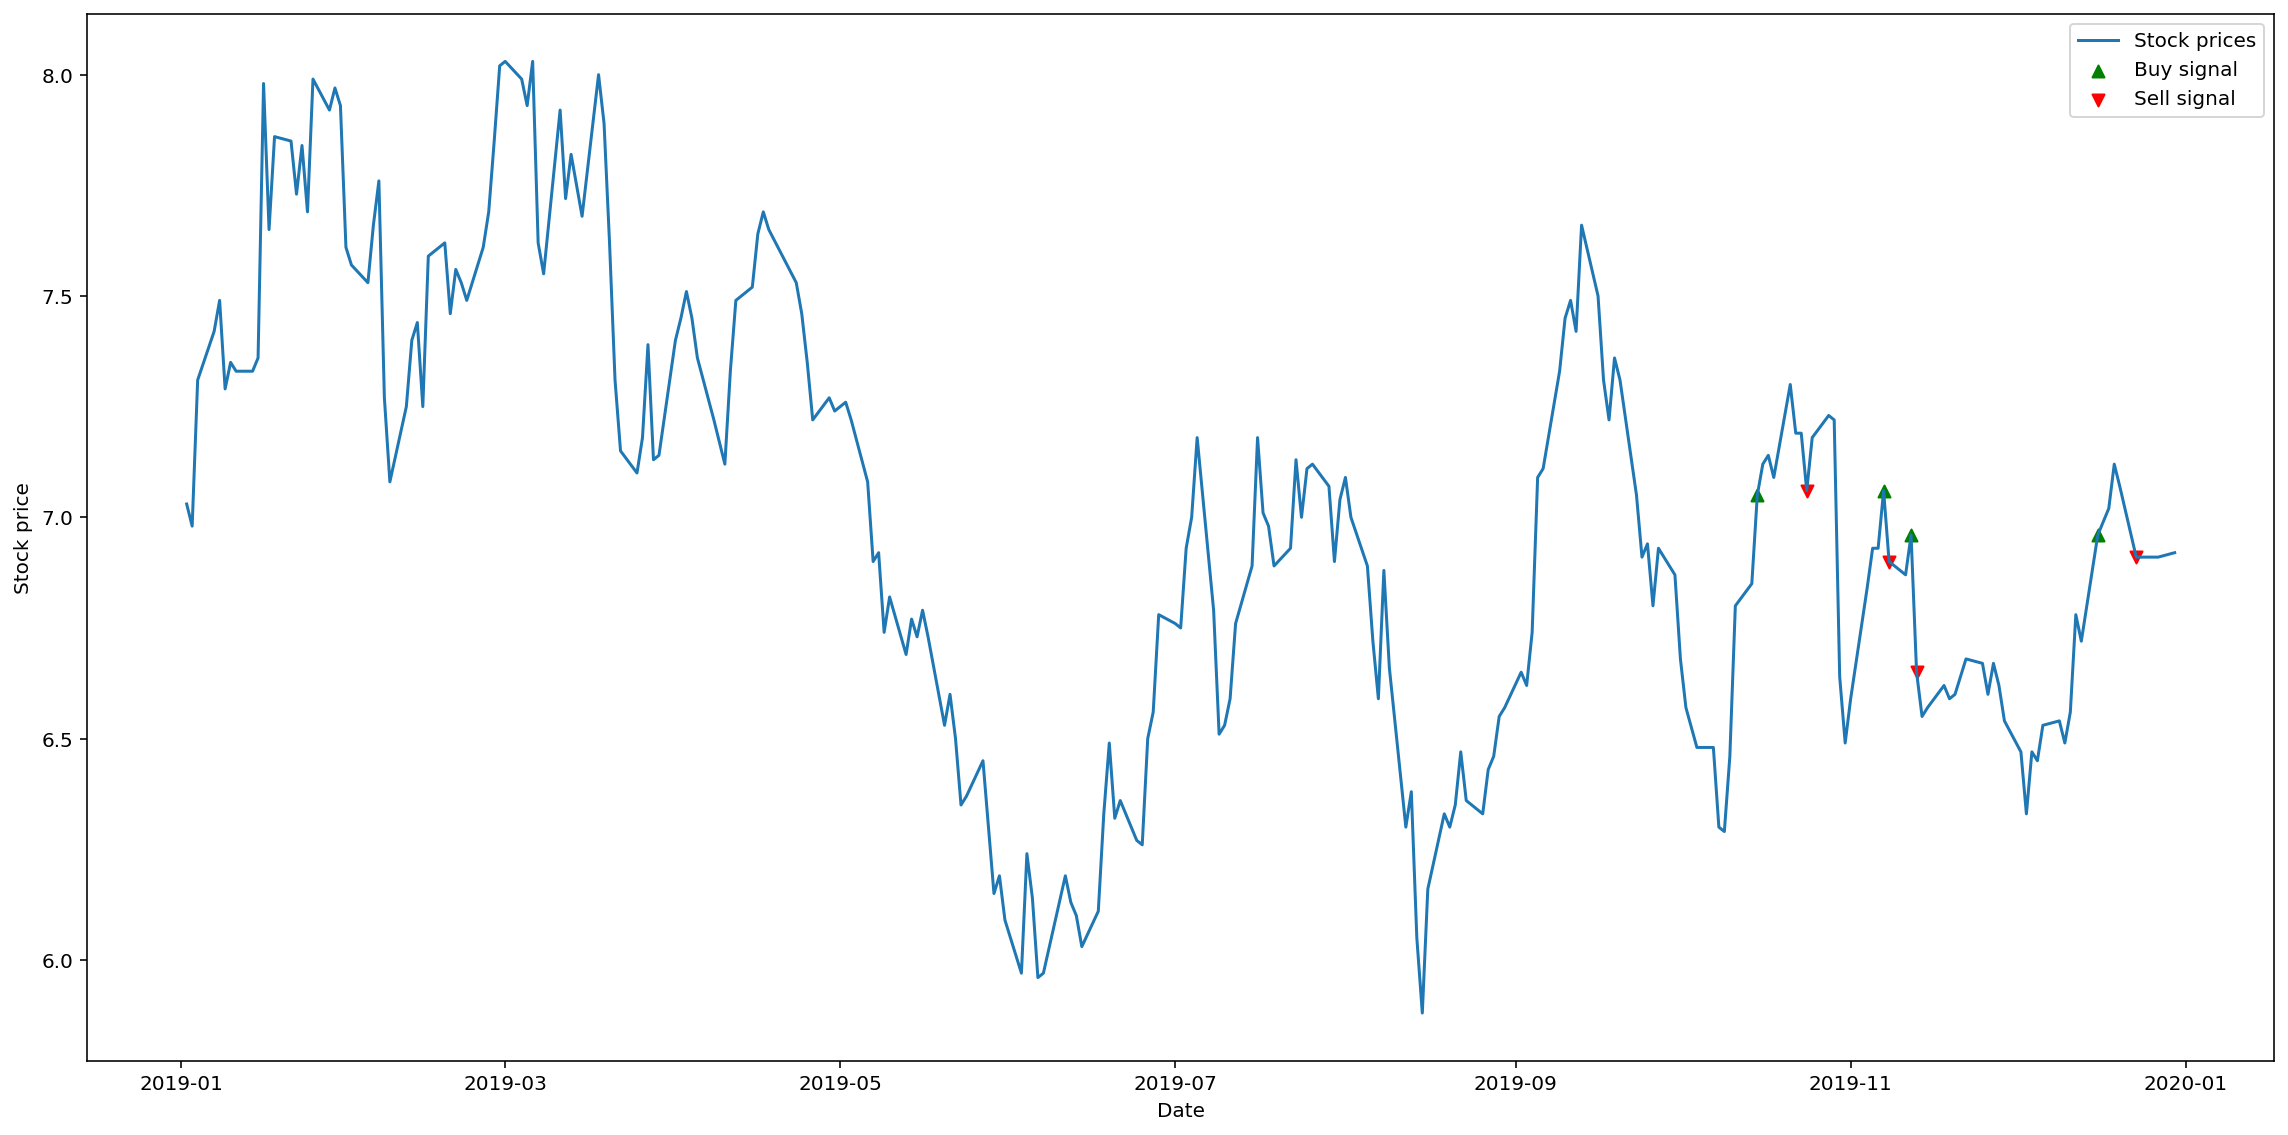

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max  	mean    	std    
0  	1000  	-10.7461	2.826	-3.02285	2.24222
1  	647   	-7.6029 	4.26373	-1.35739	1.68933
2  	648   	-9.63277	4.26373	-0.354615	1.51114
3  	669   	-8.0396 	4.26323	0.254931 	1.57878
4  	659   	-9.63277	4.26323	0.808219 	1.64162
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
Best average net profit: 0.3918551200464907
CPU times: user 6min 23s, sys: 360 ms, total: 6min 23s
Wall time: 6min 24s


In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[127, 210], [13, 36, 126], [211], [58, 5]]
Net profit of strategy: 1.235675
Net profit of buy and hold: 0.314450
Percentage profit of strategy: 9.564048%
Percentage profit of buy and hold: 2.433824%
Number of buy signals: 2
Number of sell signals: 2


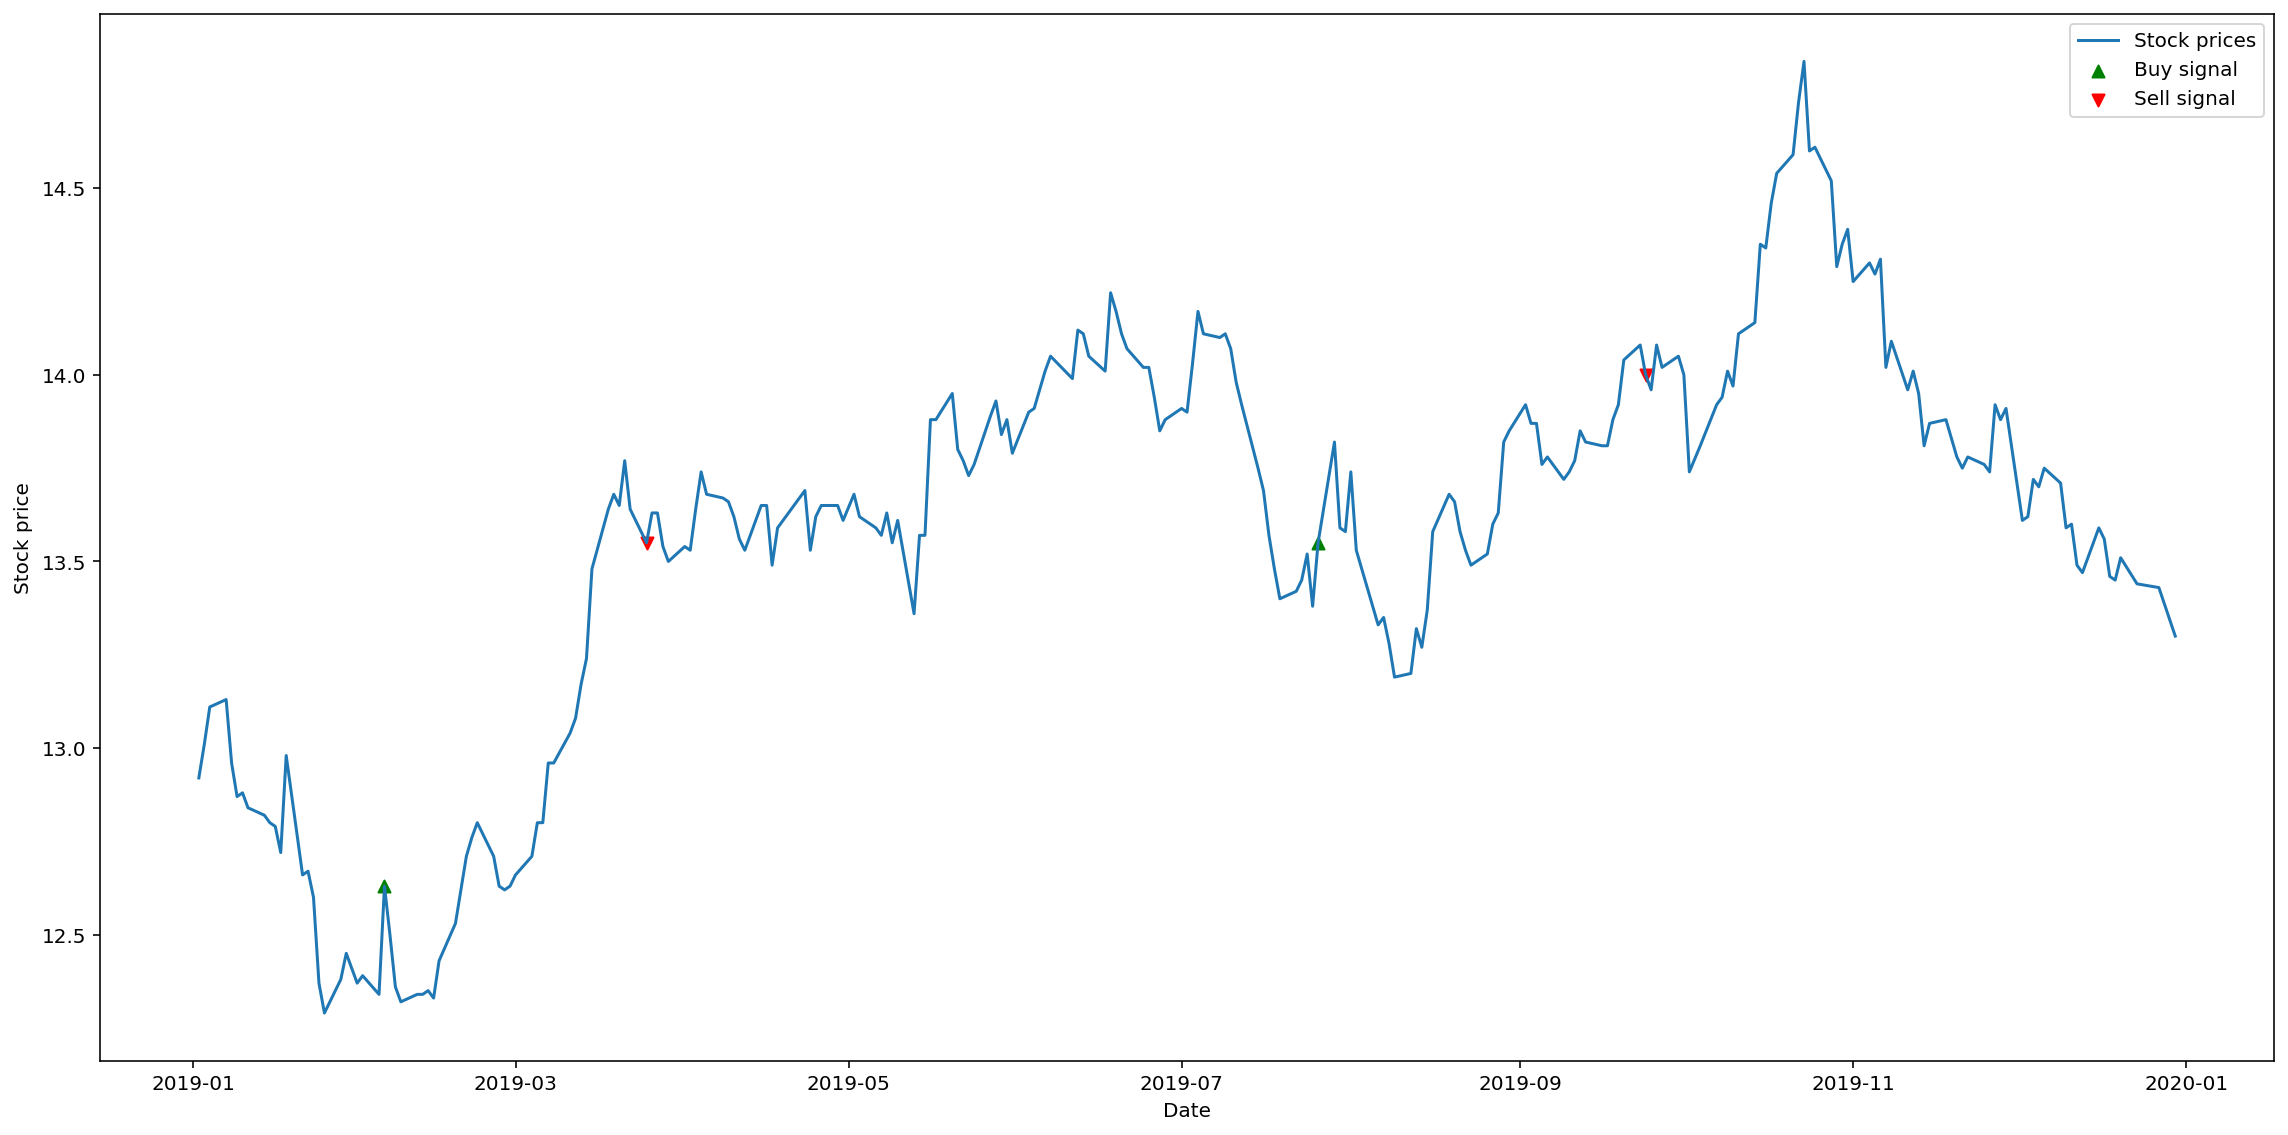

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-79.7186	26.6214	-13.8564	16.2574
1  	647   	-73.5939	26.6214	-2.55825	11.4375
2  	648   	-40.2118	28.3558	3.44677 	10.0258
3  	669   	-42.2204	28.631 	7.37    	9.83827
4  	659   	-49.2366	30.1307	10.0832 	10.5198
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Best average net profit: 2.531968170525529
CPU times: user 6min 25s, sys: 378 ms, total: 6min 25s
Wall time: 6min 26s


In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[23, 51, 72], [41, 2]]
Net profit of strategy: -8.431525
Net profit of buy and hold: 32.969475
Percentage profit of strategy: -10.113380%
Percentage profit of buy and hold: 39.545970%
Number of buy signals: 1
Number of sell signals: 1


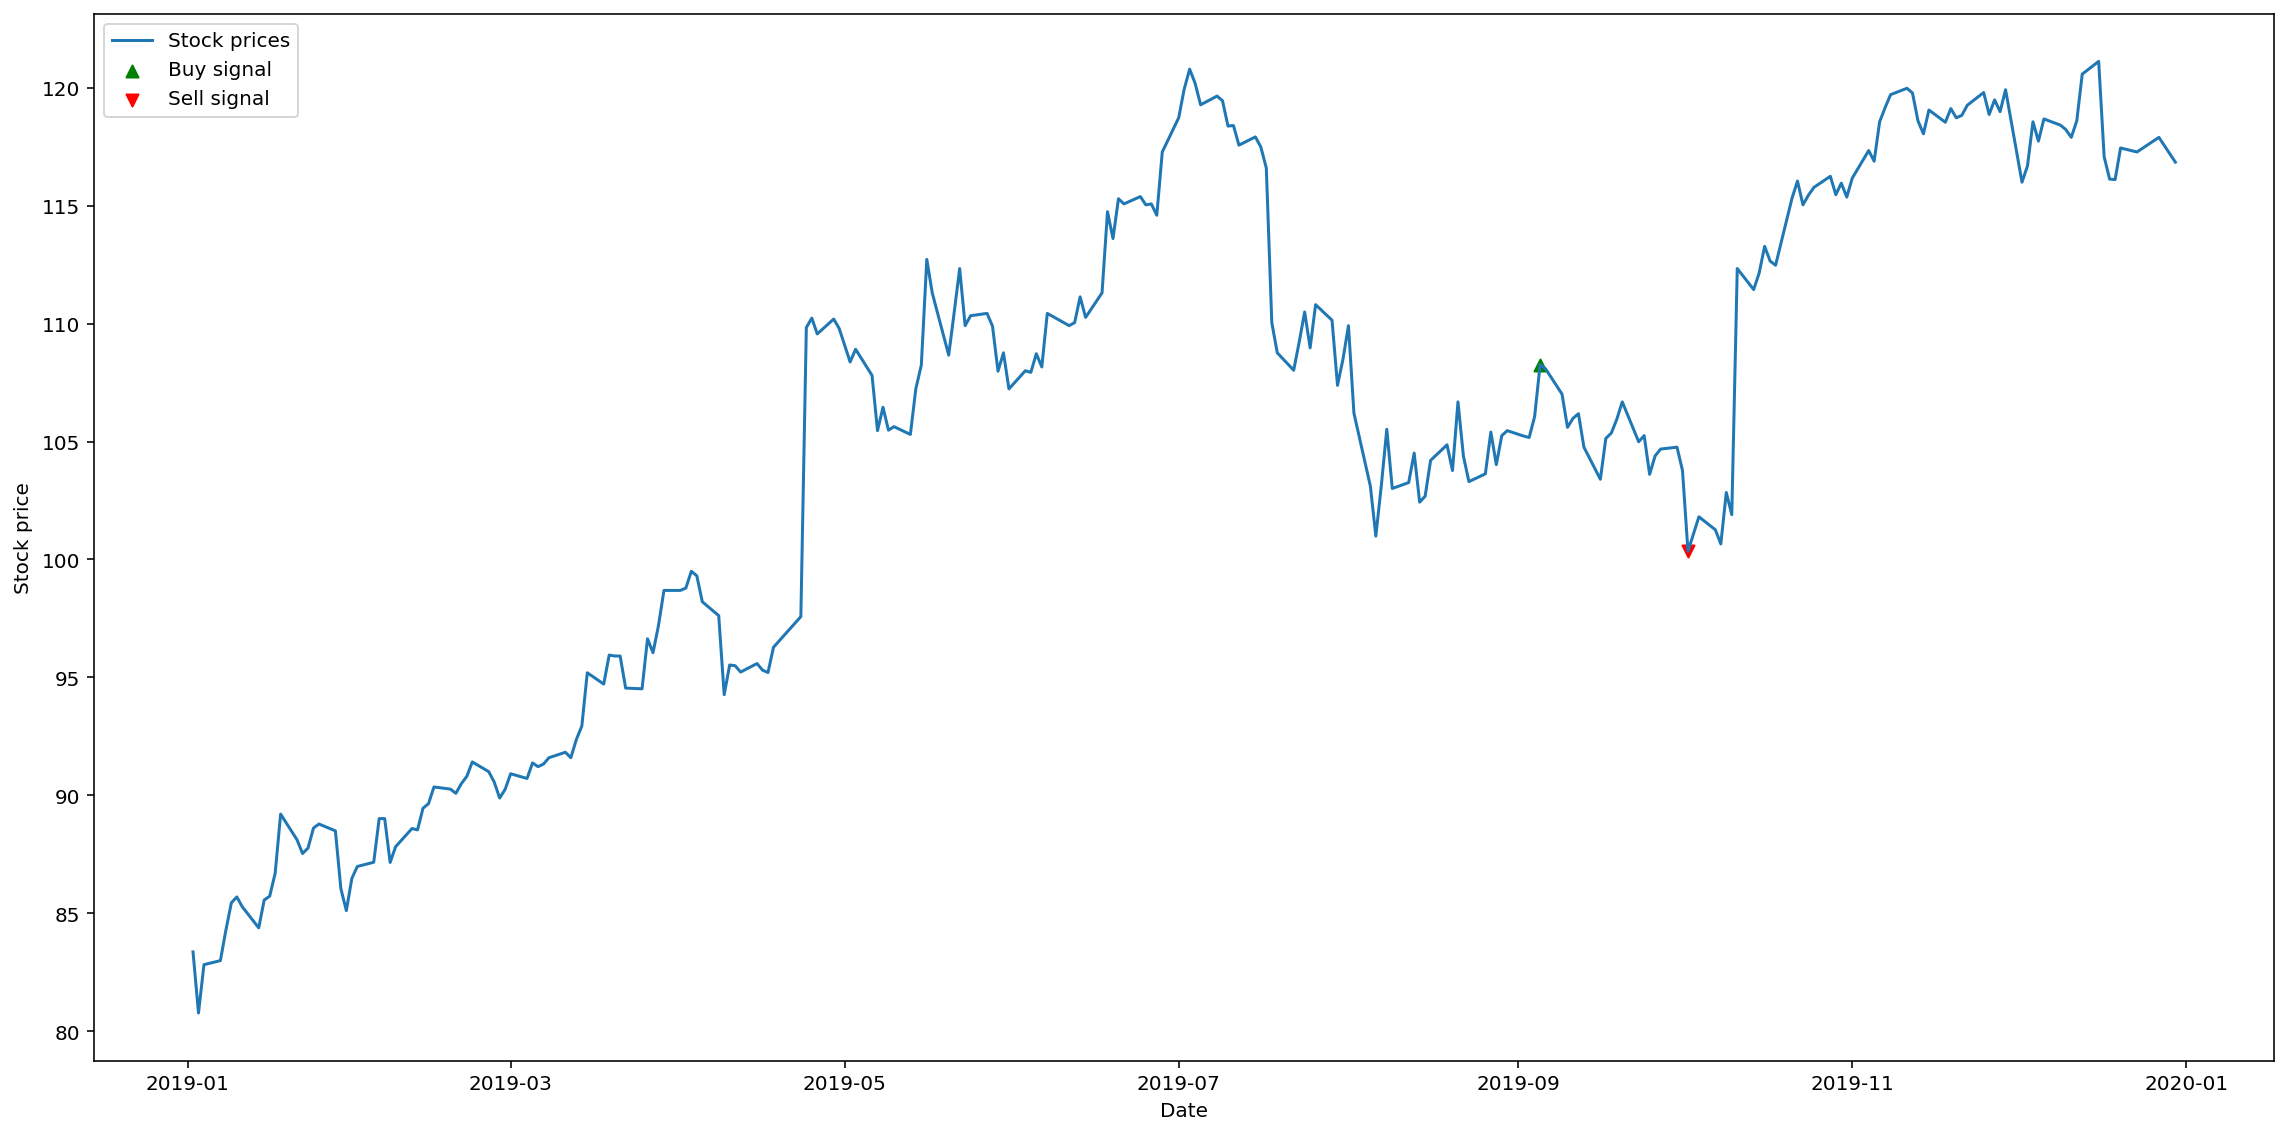

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17673.4	5972.46	-404.667	3075.28
1  	647   	-9945.13	6545.39	1376.22 	2027.9 
2  	648   	-12697  	7142.06	2388.18 	2060.13
3  	669   	-14101.2	8316.11	3041.42 	2079.32
4  	659   	-9810.66	8316.11	3655.94 	2069.86
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
Best average net profit: 1292.829172888069
CPU times: user 6min 46s, sys: 289 ms, total: 6min 47s
Wall time: 6min 47s


In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2019-01-01', end='2019-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'BollingerBaender']
Active rules' parameters: [[71, 186], [6, 48, 9], [54, 7]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 2519.888500
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 10.796114%
Number of buy signals: 0
Number of sell signals: 0


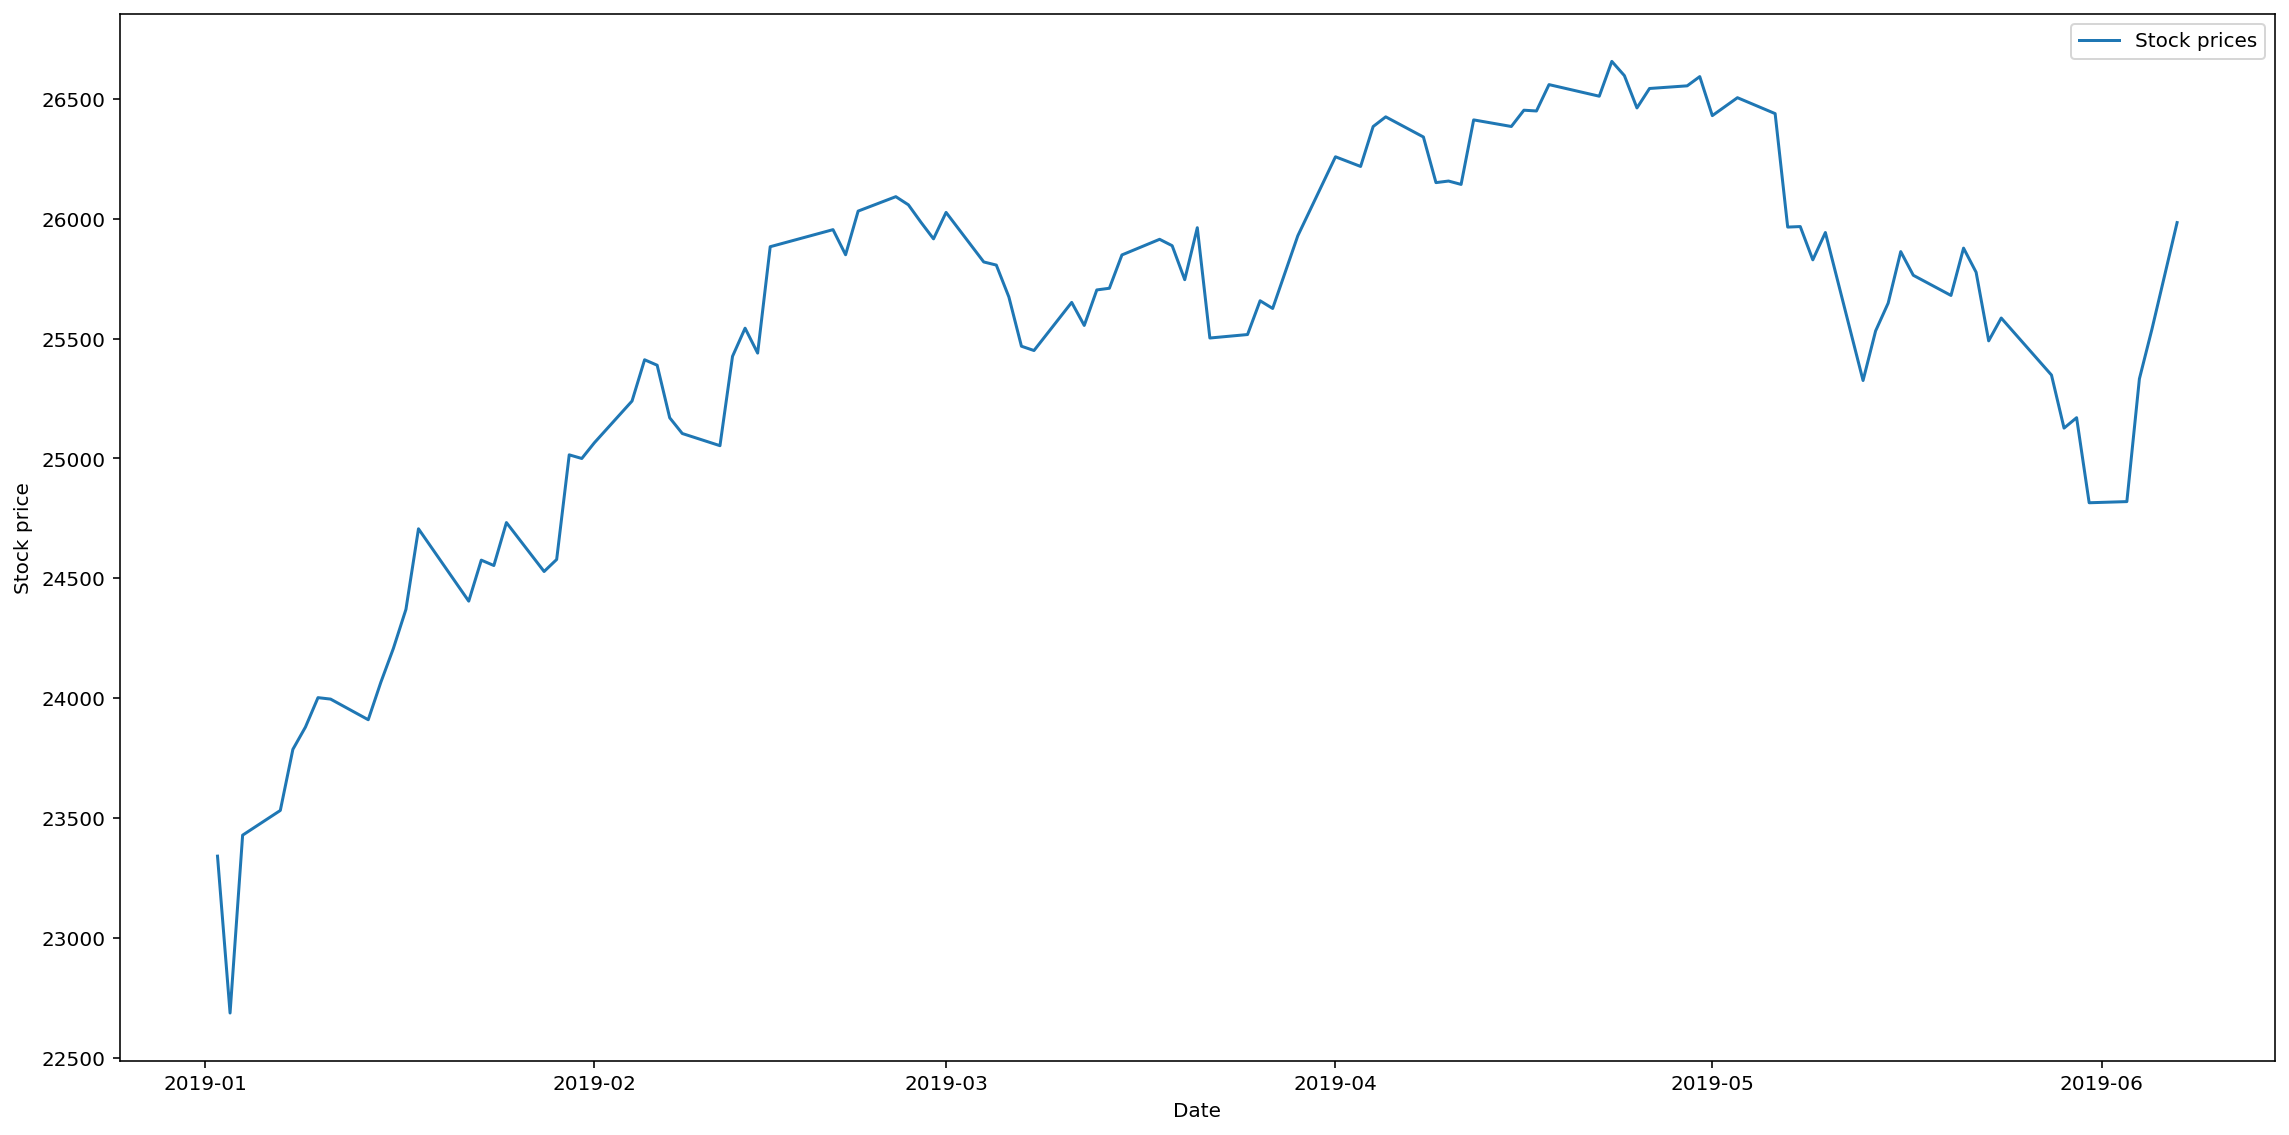

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2019-01-01', end='2019-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std    
0  	1000  	-30.2527	18.4991	-0.334673	6.64861
1  	647   	-27.8999	18.1699	3.58347  	5.41655
2  	648   	-28.57  	18.1699	6.52236  	5.13661
3  	669   	-19.3751	19.0814	8.99569  	5.3376 
4  	659   	-28.7245	19.0814	11.207   	5.38545
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Best average net profit: 2.5825290116947297
CPU times: user 6min 7s, sys: 189 ms, total: 6min 7s
Wall time: 6min 8s


In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'STO', 'MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[217], [45, 54], [32, 11, 37], [116, 57, 28], [49, 4]]
Net profit of strategy: 0.314000
Net profit of buy and hold: 5.462050
Percentage profit of strategy: 0.770552%
Percentage profit of buy and hold: 13.403804%
Number of buy signals: 17
Number of sell signals: 17


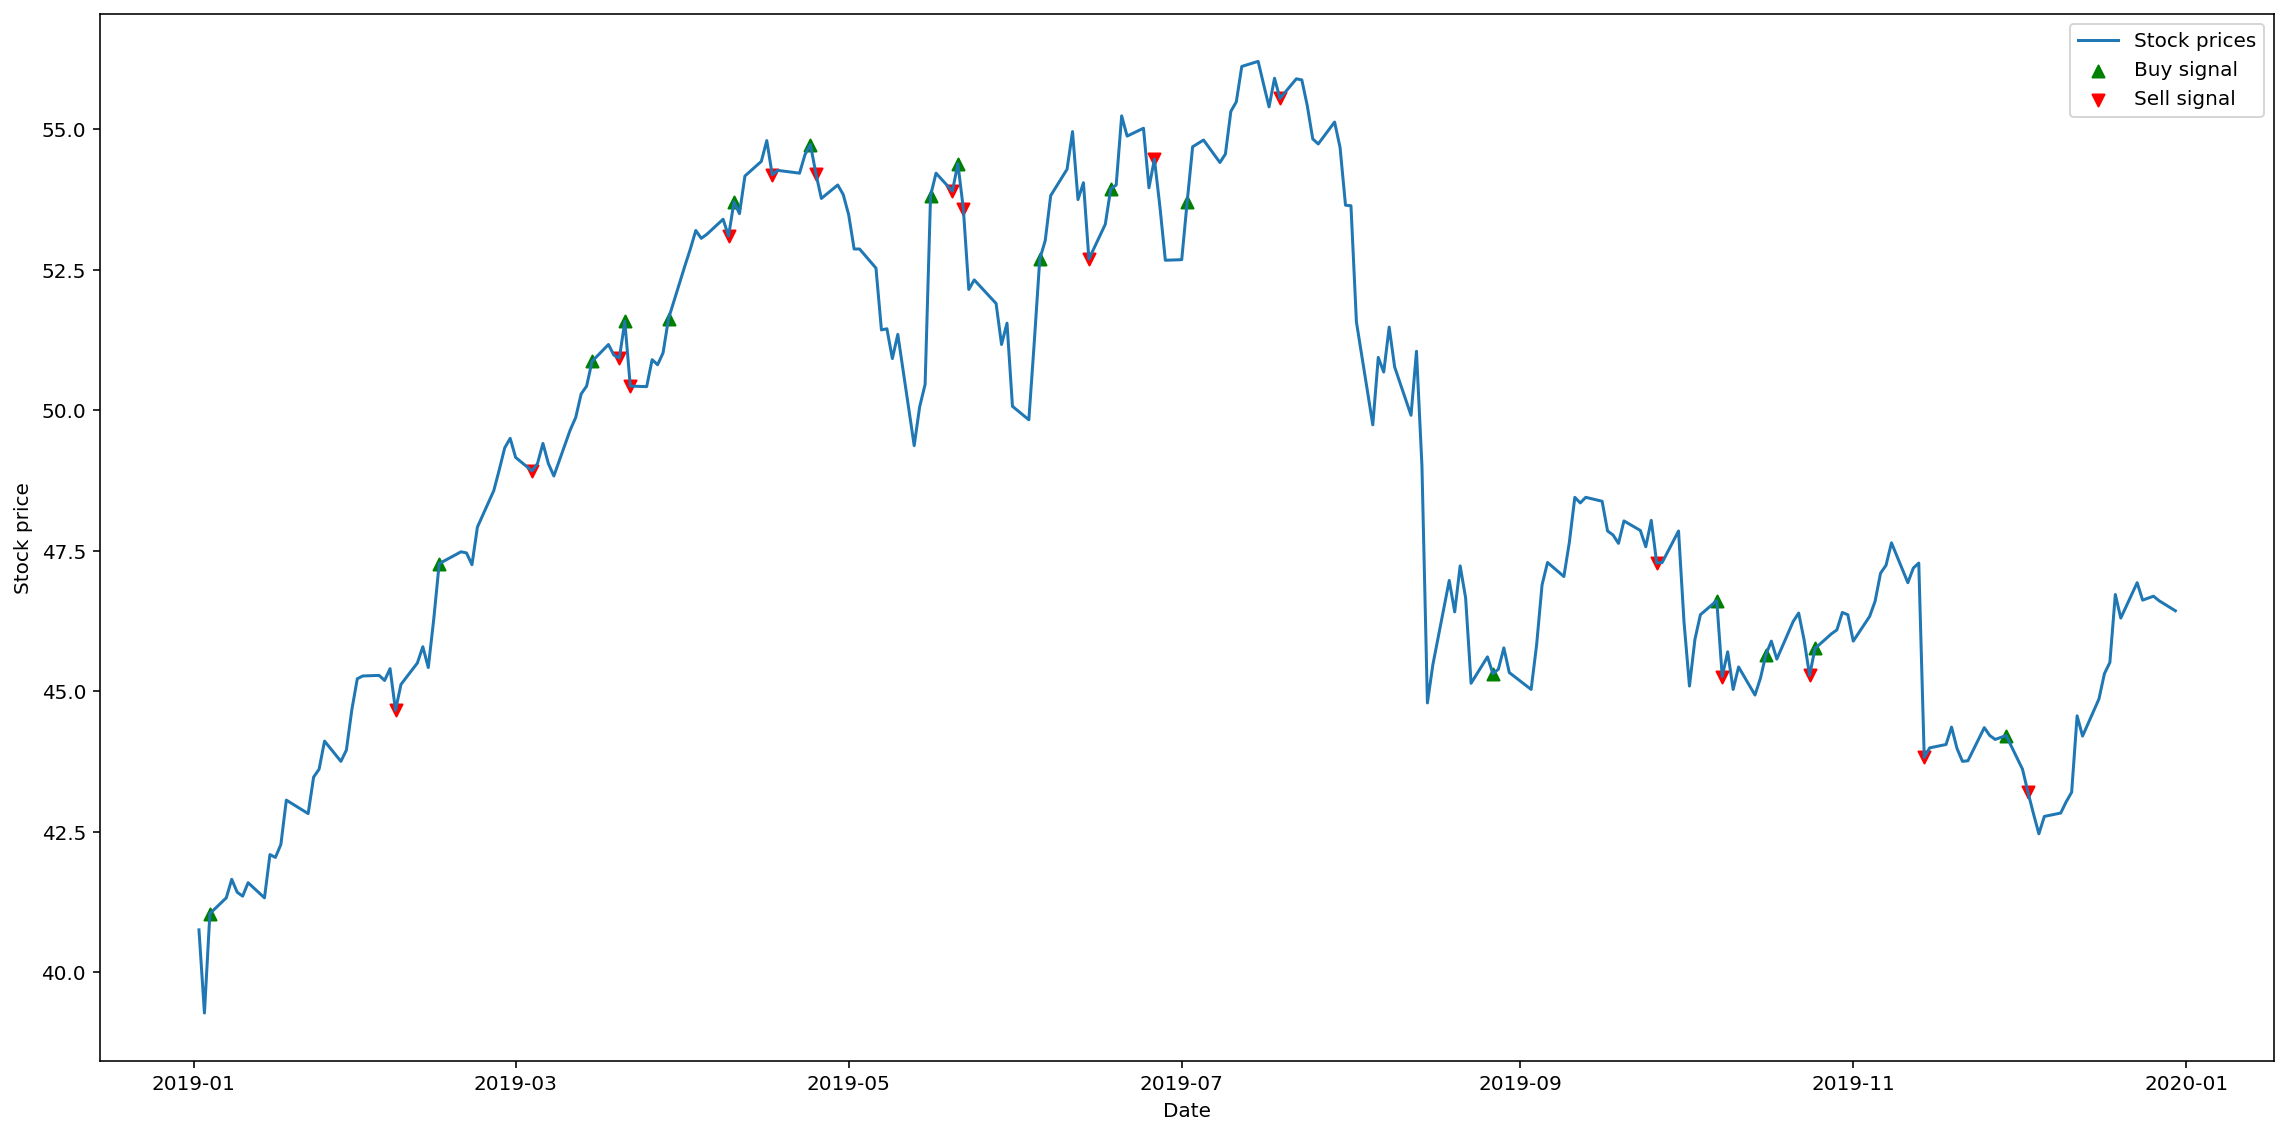

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-74.4476	25.2777	-17.3998	14.5641
1  	647   	-74.0175	23.2855	-7.93464	11.4154
2  	648   	-71.8792	23.6498	-1.57176	11.2576
3  	669   	-75.9978	29.8711	3.64463 	10.0904
4  	659   	-76.794 	29.8711	7.06575 	11.3253
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best average net profit: 5.94700850071776
CPU times: user 6min 18s, sys: 203 ms, total: 6min 18s
Wall time: 6min 19s


In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2019-01-01', end='2019-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[37, 49, 62], [31, 7]]
Net profit of strategy: 0.000000
Net profit of buy and hold: -13.107875
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: -17.722925%
Number of buy signals: 0
Number of sell signals: 0


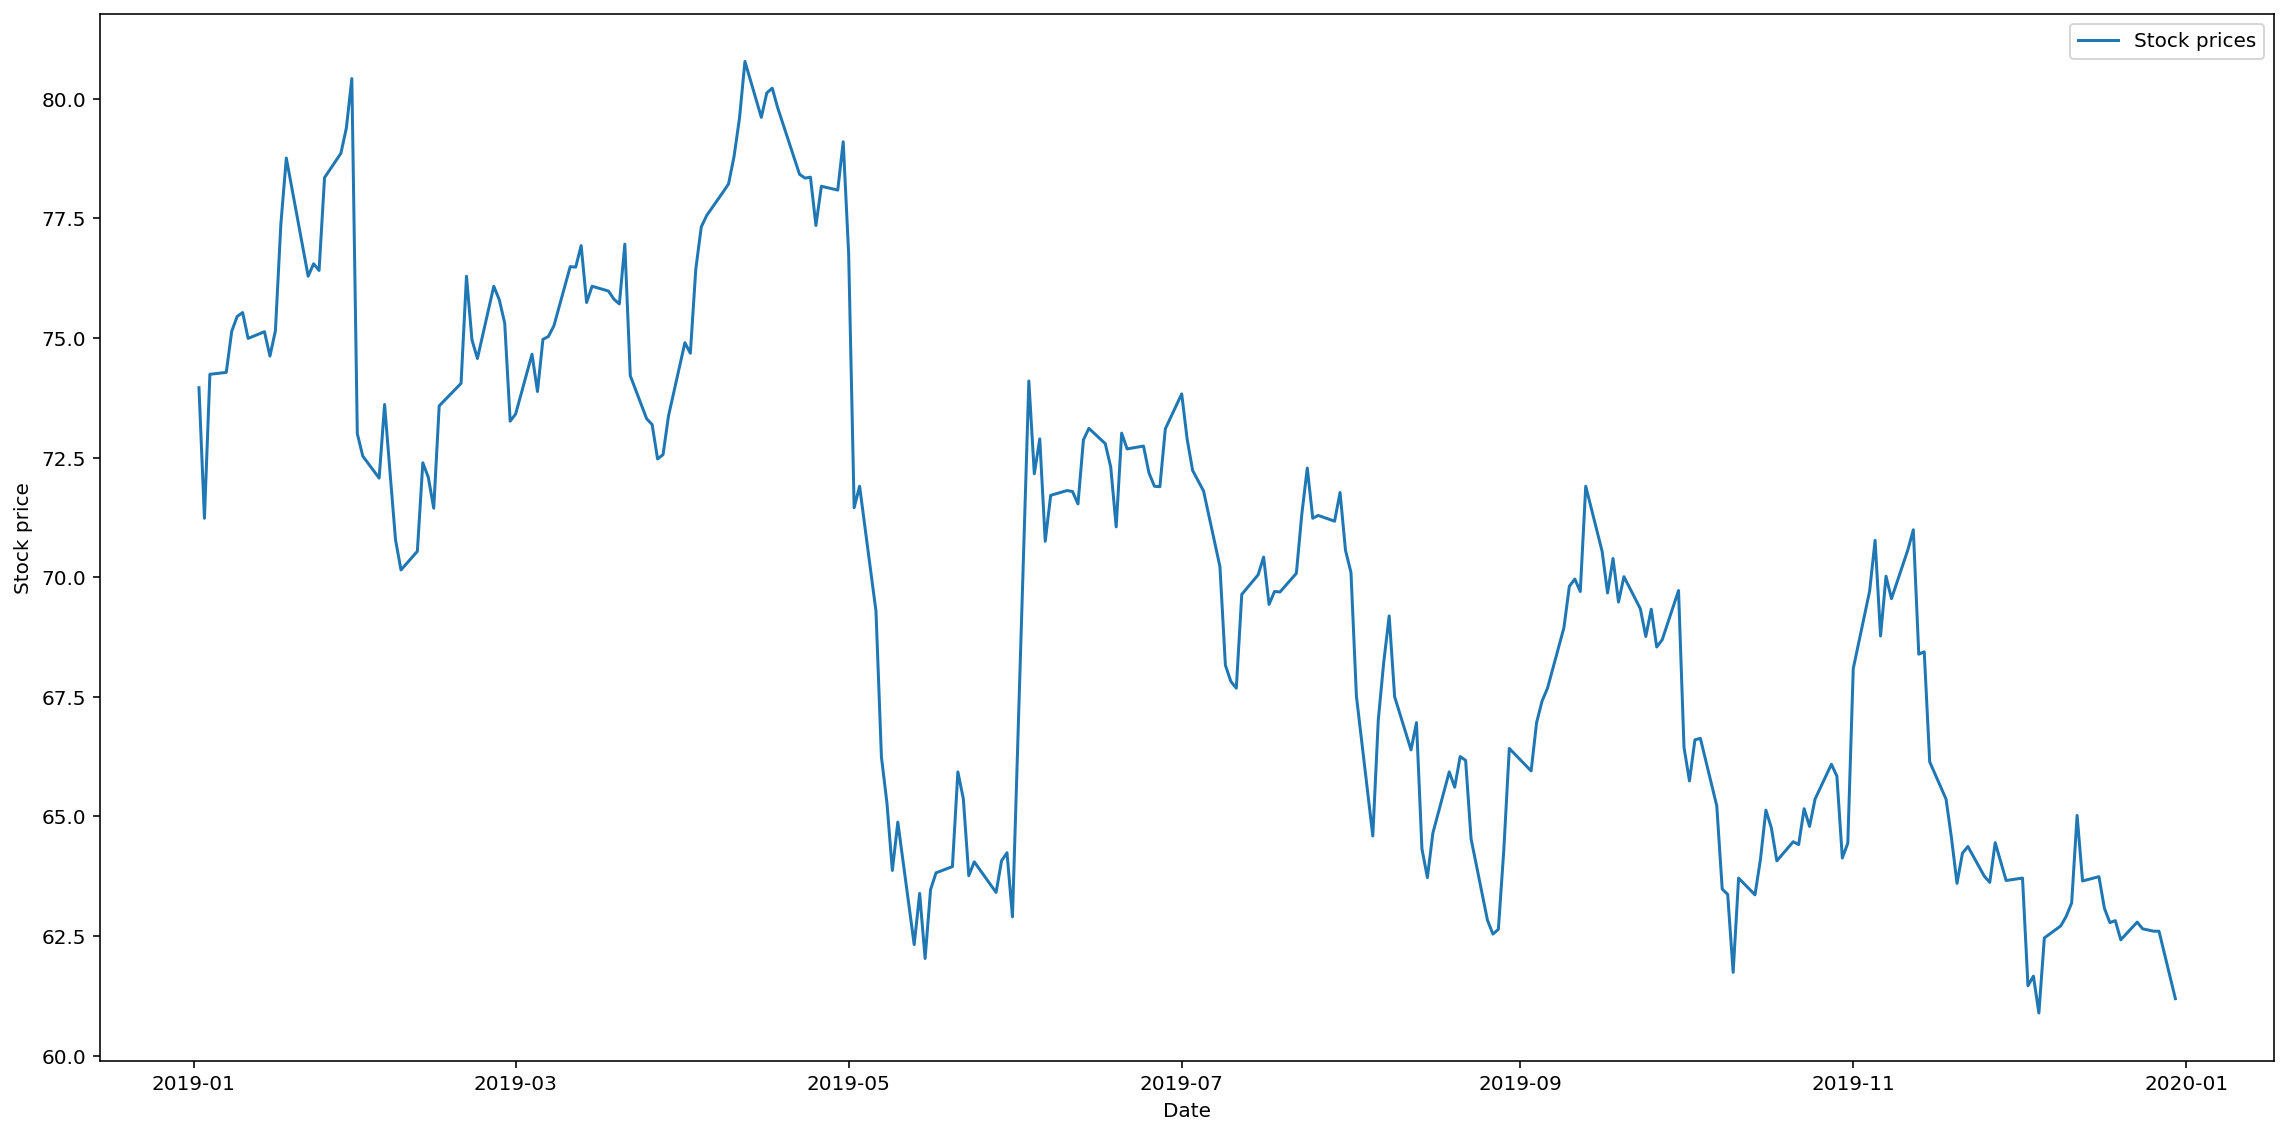

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2019-01-01', end='2019-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-74.7012	37.1167	-2.4189	15.5381
1  	647   	-68.5956	42.7461	7.86333	11.7589
2  	648   	-72.8102	46.1583	13.4008	11.3778
3  	669   	-45.5372	50.7906	18.3404	11.0528
4  	659   	-70.1652	50.7906	21.6321	11.9032
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
Best average net profit: 5.656870274250992
CPU times: user 6min 5s, sys: 225 ms, total: 6min 5s
Wall time: 6min 5s


In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2019-01-01', end='2019-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'MACD', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[245], [26, 39, 62], [134, 61, 10], [208], [39, 4]]
Net profit of strategy: 9.377550
Net profit of buy and hold: 40.648000
Percentage profit of strategy: 9.998454%
Percentage profit of buy and hold: 43.339375%
Number of buy signals: 5
Number of sell signals: 5


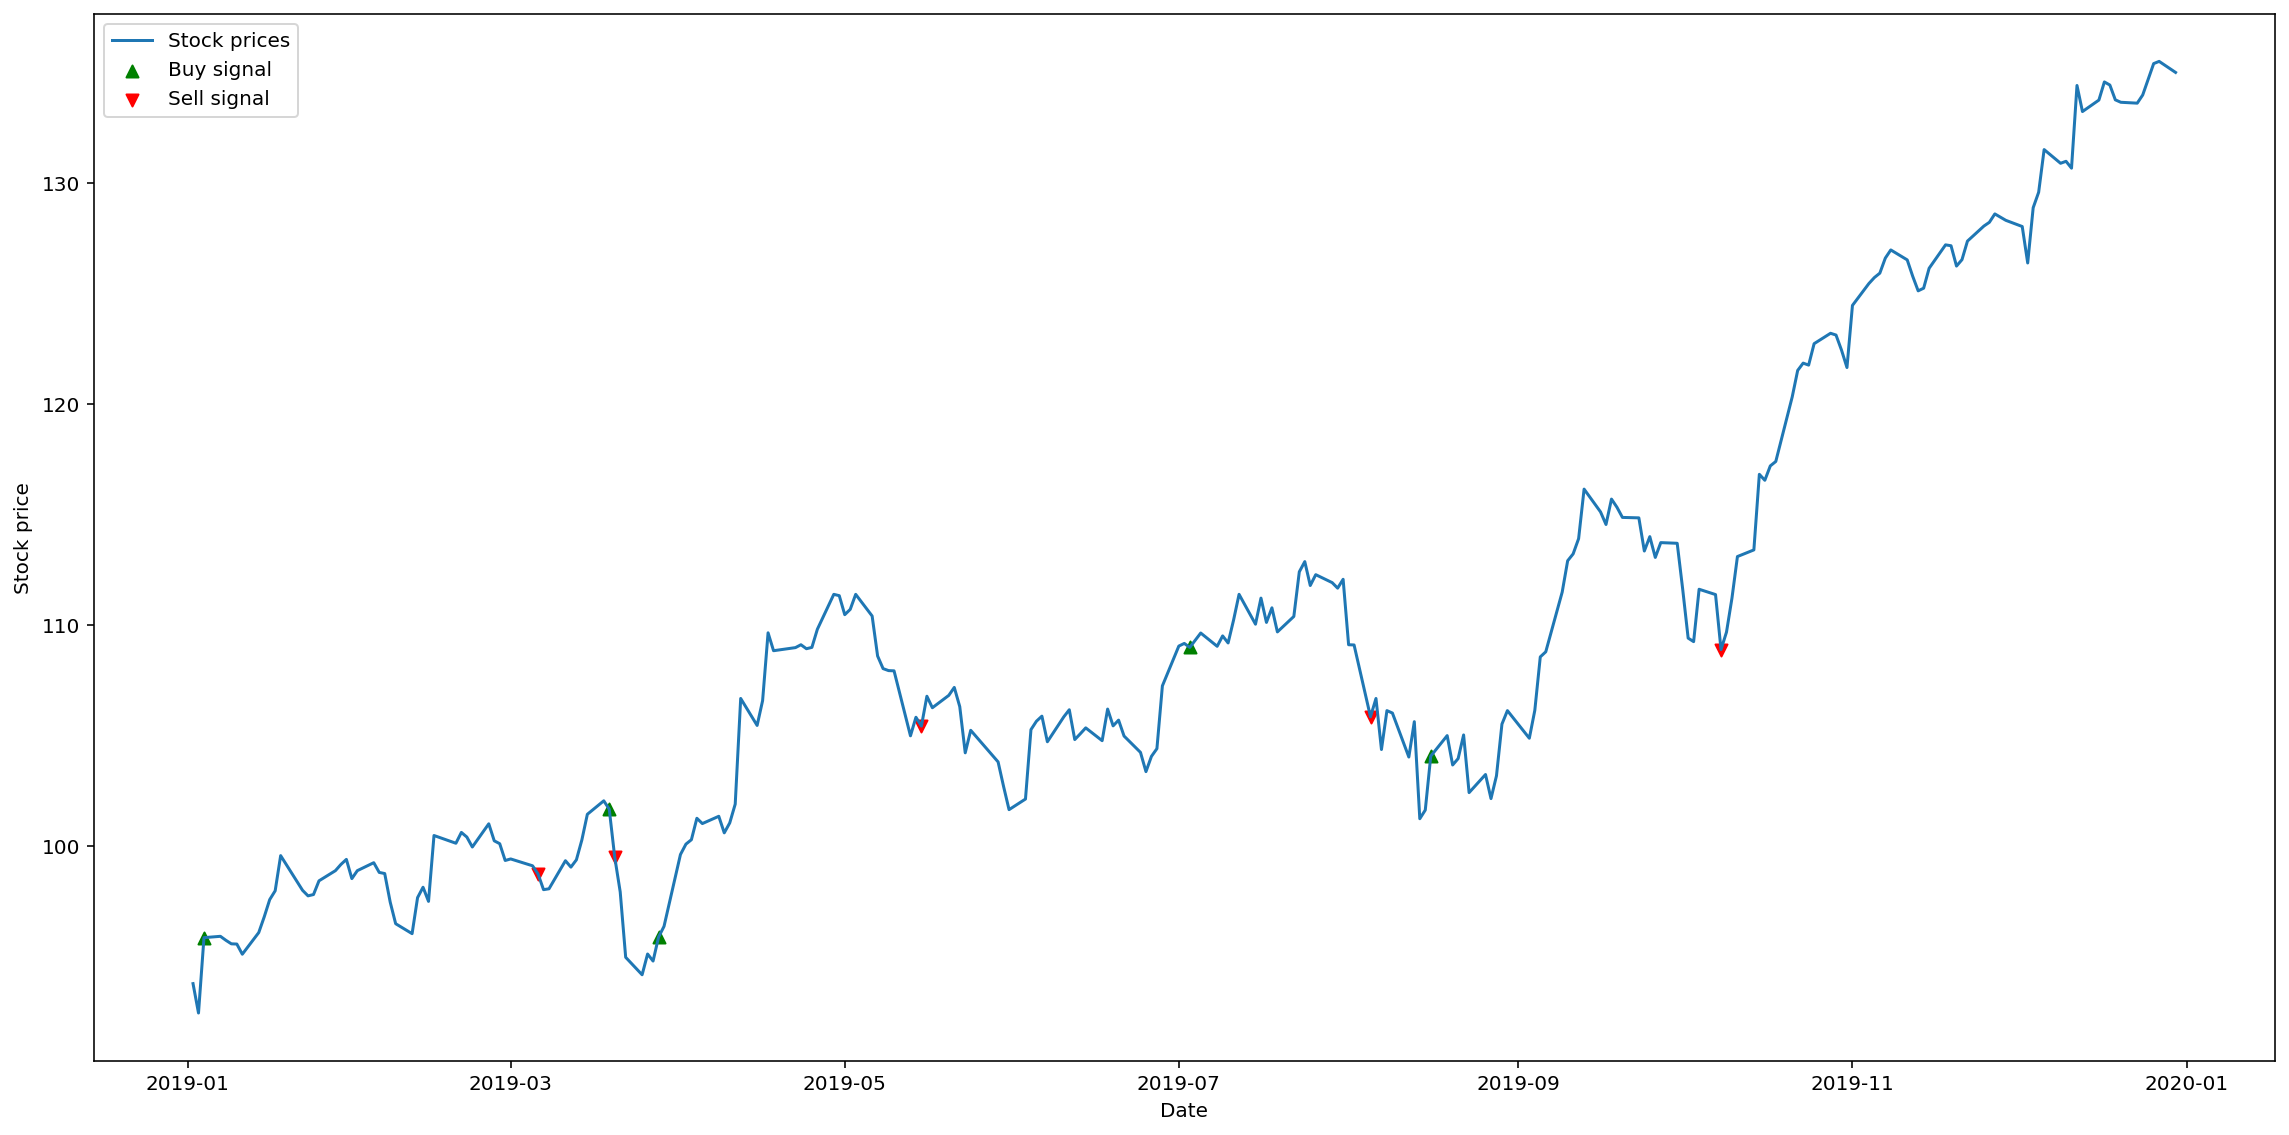

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2019-01-01', end='2019-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-90.2665	44.3764	-13.9853	18.9319
1  	647   	-87.2022	50.3406	-1.07631	17.3366
2  	648   	-81.5542	50.3406	9.14897 	18.6095
3  	669   	-83.7469	50.3406	20.5692 	19.8821
4  	659   	-87.2022	51.0385	31.4199 	17.5118
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Best average net profit: 3.5348643048574093
CPU times: user 5min 31s, sys: 180 ms, total: 5min 31s
Wall time: 5min 31s


In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[239], [84, 44, 12], [153], [33, 2]]
Net profit of strategy: 17.905625
Net profit of buy and hold: 56.851975
Percentage profit of strategy: 18.112103%
Percentage profit of buy and hold: 57.507561%
Number of buy signals: 1
Number of sell signals: 1


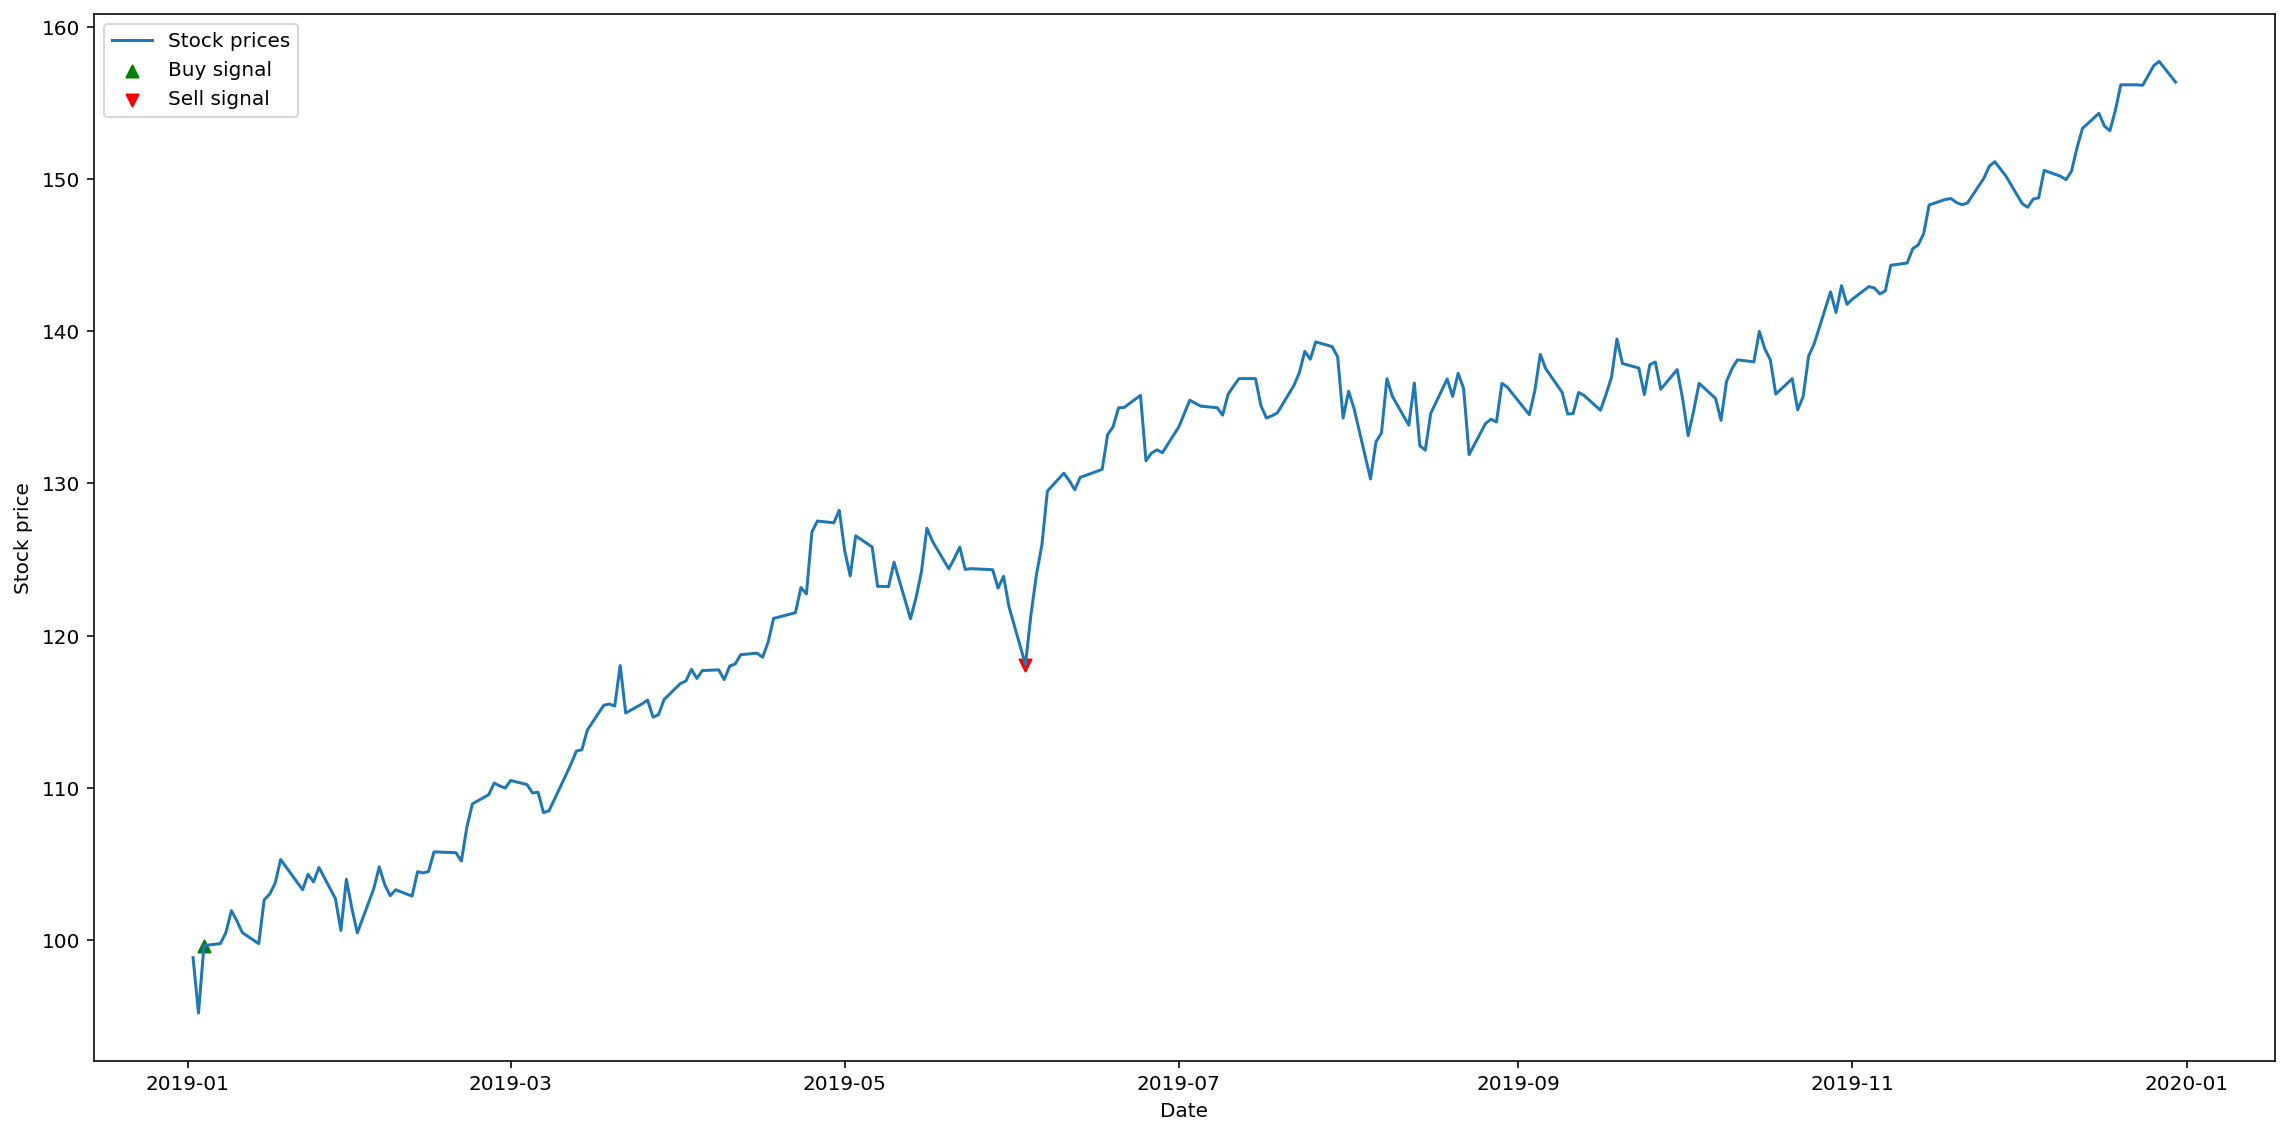

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.8786	20.4213	-15.7115	13.7108
1  	647   	-74.4536	24.633 	-6.11158	9.96536
2  	648   	-75.1182	27.1156	-0.608218	9.55817
3  	669   	-73.9658	27.1156	3.32626  	9.62965
4  	659   	-74.1852	28.694 	6.81589  	10.4463
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Best average net profit: 5.645881540754345
CPU times: user 6min 49s, sys: 211 ms, total: 6min 49s
Wall time: 6min 50s


In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2019-01-01', end='2019-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[7, 44, 124], [214], [62, 6]]
Net profit of strategy: 8.691100
Net profit of buy and hold: 26.878025
Percentage profit of strategy: 11.948172%
Percentage profit of buy and hold: 36.950818%
Number of buy signals: 4
Number of sell signals: 4


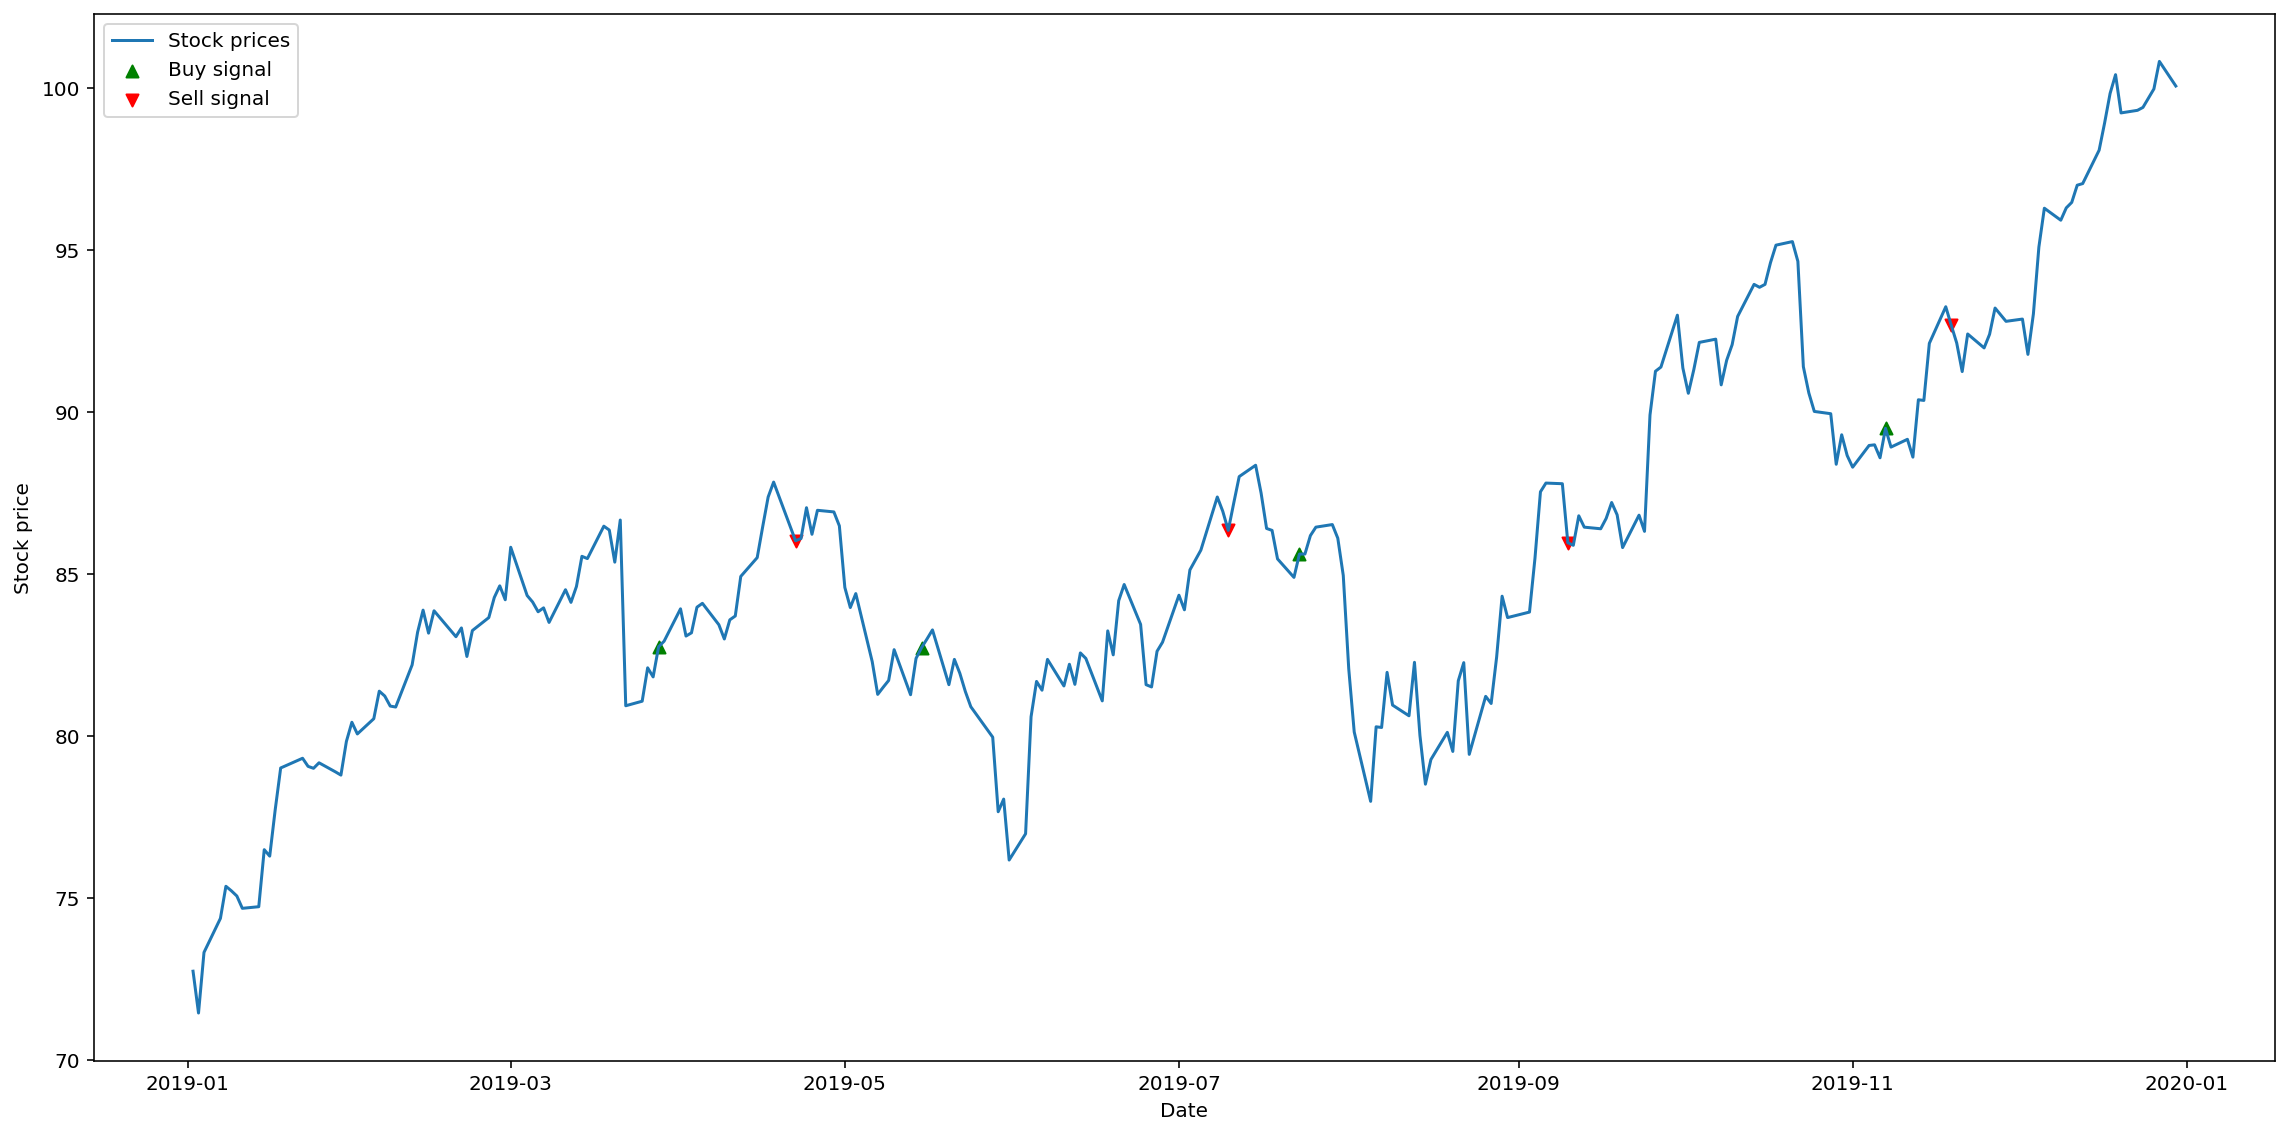

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2019-01-01', end='2019-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2016-01-01', end='2018-12-31', ngen=4)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-100.878	133.353	1.38446	38.3464
1  	647   	-55.3134	133.353	28.8446	39.0629
2  	648   	-83.6754	133.353	50.553 	44.1899
3  	669   	-69.6497	133.353	75.1767	46.1746
4  	659   	-49.1791	136.581	101.177	40.7868
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 20.619852213772287
CPU times: user 6min 8s, sys: 192 ms, total: 6min 8s
Wall time: 6min 9s


In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2019-01-01', end='2019-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[155], [38, 85, 126], [176], [12, 7]]
Net profit of strategy: -37.436175
Net profit of buy and hold: 52.403650
Percentage profit of strategy: -15.835276%
Percentage profit of buy and hold: 22.166427%
Number of buy signals: 11
Number of sell signals: 11


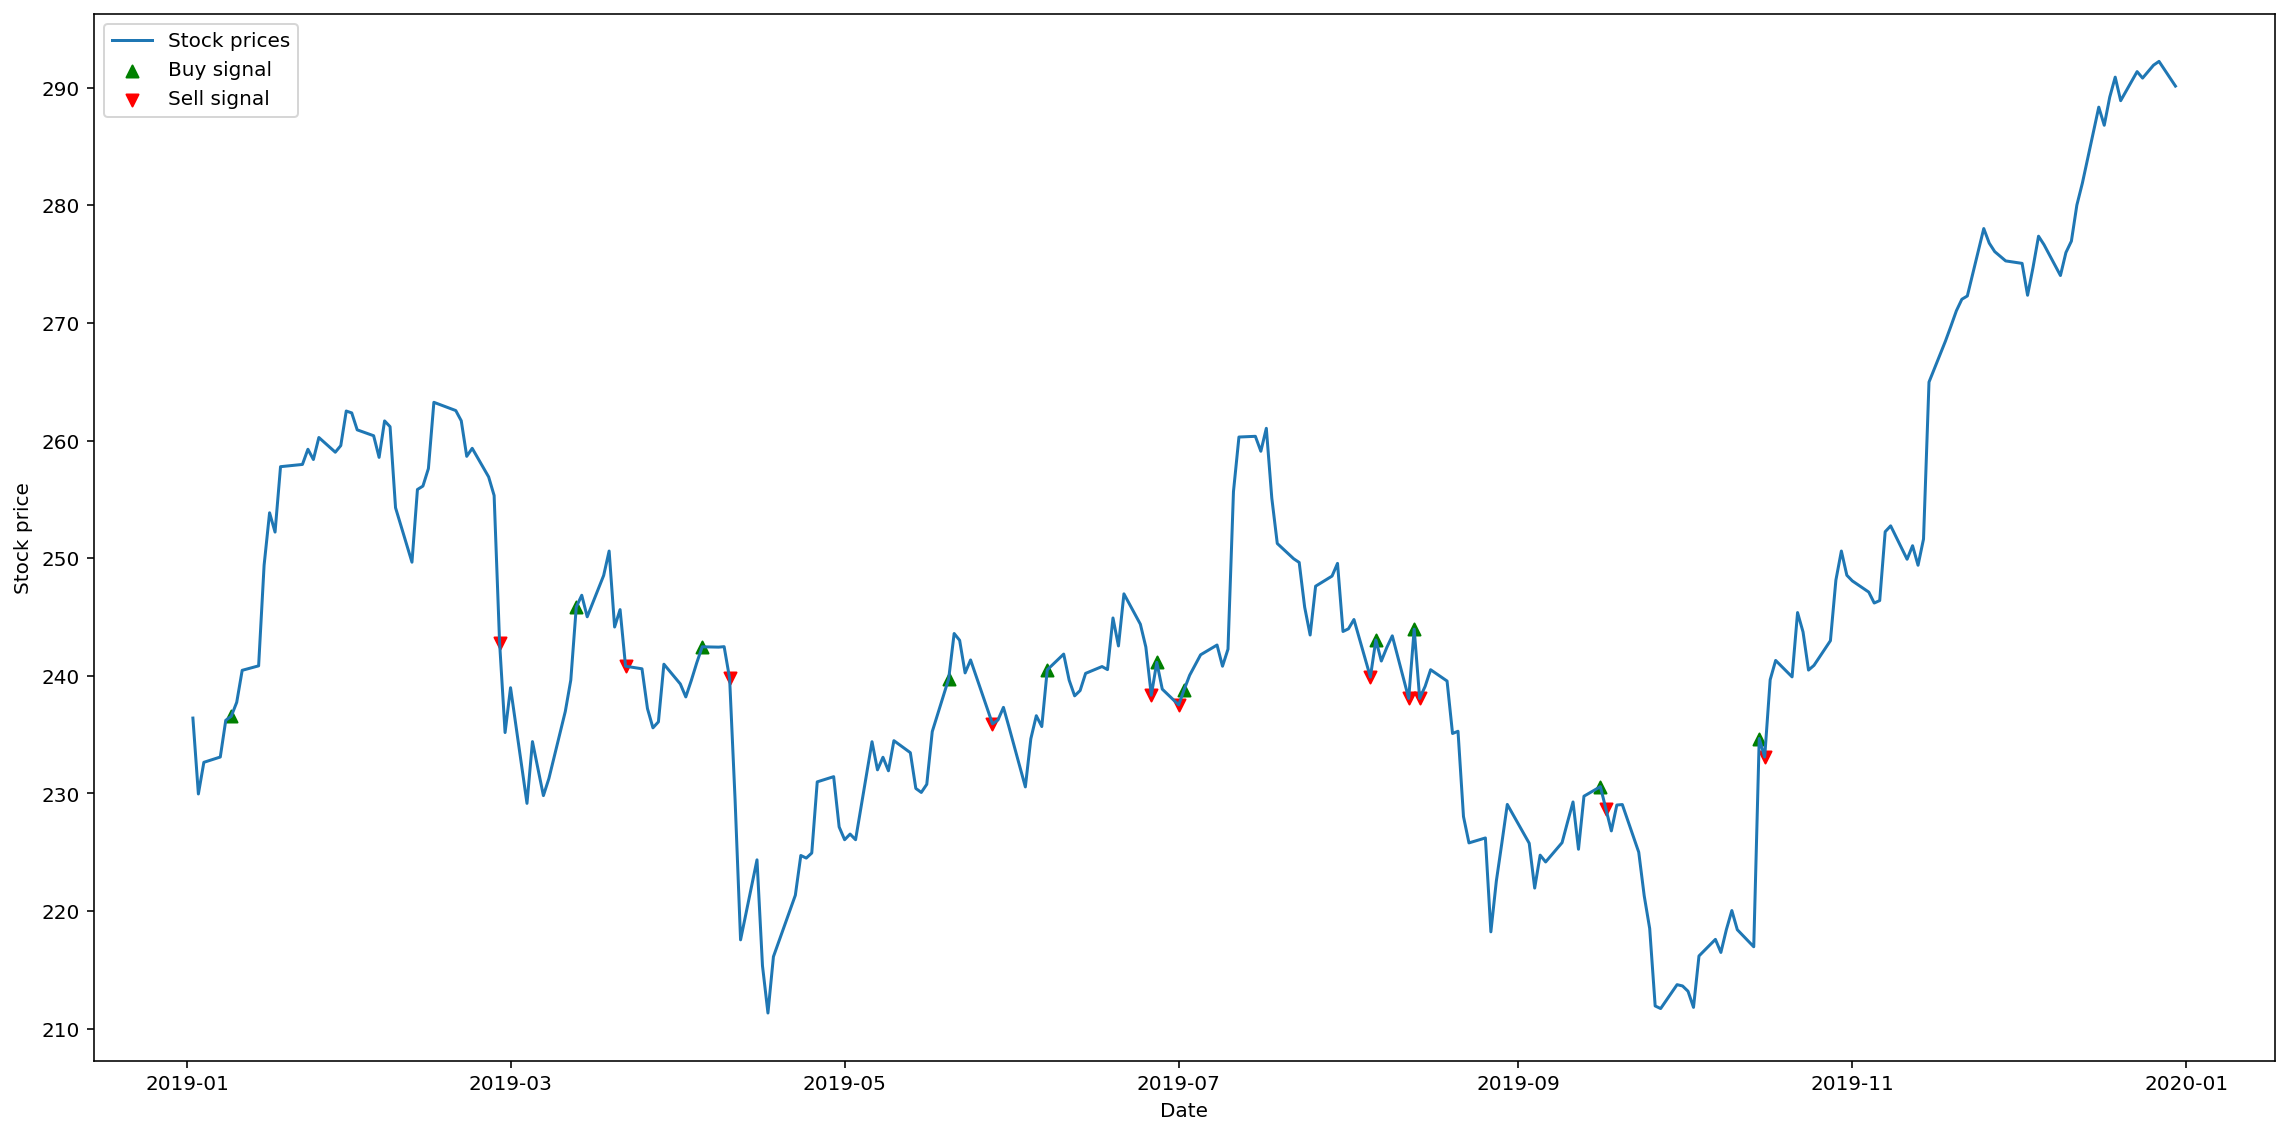

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2019-01-01', end='2019-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[11.608161474330835, 24.010750329091714]","[0.0, 58.64860659414599]","[19.171492063492053, 29.842999999999996]","[24.791905231984295, 15.491510365251738]","[-9.230085348506423, -2.060810810810815]","[9.564047987616107, 2.4338235294117707]","[-10.113380112750402, 39.54596977329974]","[0.0, 10.796113655545895]","[0.7705521472391288, 13.403803680981593]","[0.0, -17.72292455381287]","[9.998453992963059, 43.339375199914684]","[18.112102973902477, 57.507561197653246]","[11.948171569975278, 36.95081798185318]","[-15.835275580559365, 22.166426970094328]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

5.0561533142633595

In [52]:
np.mean(bh_results)

23.882430279472867